# Cryptocurrency price movement forecasting with machine learning
This project explores the question of whether the advanced machine learning models are cabable of producing better than naive (no change in price) short-term forecasts for cryptocurrency prices. The null hypothesis is that the price fluctuations are completely unpredictable, and that any model's accuracy will eventually converge to 50% as the test set grows in size.

In [84]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import dateutil
import ta
import math
import random
from itertools import product
from datetime import datetime, timedelta
from io import StringIO
from dotenv import load_dotenv
from scipy import stats
from sklearn import preprocessing, model_selection, metrics, ensemble
from sklearn.base import BaseEstimator
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from lightgbm import LGBMRegressor, LGBMClassifier, plot_importance
from ngboost import NGBRegressor

In [2]:
load_dotenv()

True

### Data collection
Data is obtained from CoinAPI service and contains information on hourly open price, close price, low price, high price, volume traded and trades count for spot BTC-USD pair between 5-MAR-2021 3:00 and 7-DEC-2021 19:00 to the total of 6664 observations. The API key can be obtained at: https://www.coinapi.io/pricing?apikey

In [14]:
base_id   = 'BTC'
quote_id  = 'USD'
period_id = '1HRS'

time_end   = datetime(2021, 12, 7, 19, 0)
time_start = datetime(2021, 3, 5, 3, 0)

length = int((time_end - time_start).total_seconds() / 3600)

pred_window = 2000
end_offset  = 0

In [4]:
length

6664

In [ ]:
url = f'https://rest.coinapi.io/v1/ohlcv/{base_id}/{quote_id}/history?period_id={period_id}&time_start={time_start.strftime("%Y-%m-%dT%H:%M:%S")}&time_end={time_end.strftime("%Y-%m-%dT%H:%M:%S")}&limit={length}&output_format=csv'
headers = {'X-CoinAPI-Key' : os.environ.get("COINAPI_KEY")}

In [ ]:
response = requests.get(url, headers=headers)

In [ ]:
data = StringIO(response.content.decode('utf-8'))

df = pd.read_csv(data, sep=';', parse_dates=['time_period_start', 'time_period_end', 'time_open', 'time_close'], date_parser=dateutil.parser.parse)

In [5]:
df_path = f'./data/{base_id}-{quote_id}-{period_id}-{time_start.strftime("%Y-%m-%dT%H-%M-%S")}-{time_end.strftime("%Y-%m-%dT%H-%M-%S")}.csv'

In [ ]:
df.to_csv(df_path, index=False)

In [6]:
df = pd.read_csv(df_path, parse_dates=['time_period_start', 'time_period_end', 'time_open', 'time_close'], date_parser=dateutil.parser.parse)

In [7]:
df

time_period_start           time_period_end  \
0    2021-03-05 03:00:00+00:00 2021-03-05 04:00:00+00:00   
1    2021-03-05 04:00:00+00:00 2021-03-05 05:00:00+00:00   
2    2021-03-05 05:00:00+00:00 2021-03-05 06:00:00+00:00   
3    2021-03-05 06:00:00+00:00 2021-03-05 07:00:00+00:00   
4    2021-03-05 07:00:00+00:00 2021-03-05 08:00:00+00:00   
...                        ...                       ...   
6659 2021-12-07 14:00:00+00:00 2021-12-07 15:00:00+00:00   
6660 2021-12-07 15:00:00+00:00 2021-12-07 16:00:00+00:00   
6661 2021-12-07 16:00:00+00:00 2021-12-07 17:00:00+00:00   
6662 2021-12-07 17:00:00+00:00 2021-12-07 18:00:00+00:00   
6663 2021-12-07 18:00:00+00:00 2021-12-07 19:00:00+00:00   

                            time_open                       time_close  \
0    2021-03-05 03:00:00.013068+00:00 2021-03-05 03:59:59.503992+00:00   
1    2021-03-05 04:00:00.145181+00:00 2021-03-05 04:59:59.843509+00:00   
2    2021-03-05 05:00:00.259175+00:00 2021-03-05 05:59:59.657877+00:00   
3    2021-03-05 06:00:00.159736+00:00 2021-03-05 06:59:59.768823+00:00   
4    2021-03-05 07:00:00.428696+00:00 2021-03-05 07:59:59.992417+00:00   
...                               ...                              ...   
6659 2021-12-07 14:00:00.078000+00:00 2021-12-07 14:59:59.407109+00:00   
6660 2021-12-07 15:00:01.377645+00:00 2021-12-07 15:59:59.832704+00:00   
6661 2021-12-07 16:00:00.282000+00:00 2021-12-07 16:59:59.803691+00:00   
6662 2021-12-07 17:00:00.734000+00:00 2021-12-07 17:59:59.338187+00:00   
6663 2021-12-07 18:00:00.097229+00:00 2021-12-07 18:59:59.808244+00:00   

      price_open  price_high  price_low  price_close  volume_traded  \
0       47137.67    47396.40   46849.39     47314.09    1612.131151   
1       47312.98    47315.92   46570.53     46675.93    1259.361511   
2       46666.86    47299.00   46666.86     47144.67     971.364524   
3       47144.50    47494.39   46944.42     47398.11    1004.542029   
4       47398.12    47588.99   47025.68     47407.61     975.153212   
...          ...         ...        ...          ...            ...   
6659    50975.76    51653.52   50869.50     51536.02    1544.452948   
6660    51536.01    51995.00   51413.50     51800.41    2028.035109   
6661    51810.09    51944.92   51135.50     51400.00    1289.704329   
6662    51394.21    51419.14   50899.17     51055.32    1073.181776   
6663    51057.39    51227.60   50916.50     50976.21     786.574728   

      trades_count  
0            24944  
1            18254  
2            16526  
3            14685  
4            12773  
...            ...  
6659         24699  
6660         33613  
6661         25547  
6662         24005  
6663         21712  

[6664 rows x 10 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6664 entries, 0 to 6663
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype                  
---  ------             --------------  -----                  
 0   time_period_start  6664 non-null   datetime64[ns, tzutc()]
 1   time_period_end    6664 non-null   datetime64[ns, tzutc()]
 2   time_open          6664 non-null   datetime64[ns, tzutc()]
 3   time_close         6664 non-null   datetime64[ns, tzutc()]
 4   price_open         6664 non-null   float64                
 5   price_high         6664 non-null   float64                
 6   price_low          6664 non-null   float64                
 7   price_close        6664 non-null   float64                
 8   volume_traded      6664 non-null   float64                
 9   trades_count       6664 non-null   int64                  
dtypes: datetime64[ns, tzutc()](4), float64(5), int64(1)
memory usage: 520.8 KB


In [9]:
prices = ['price_open', 'price_close', 'price_high', 'price_low']

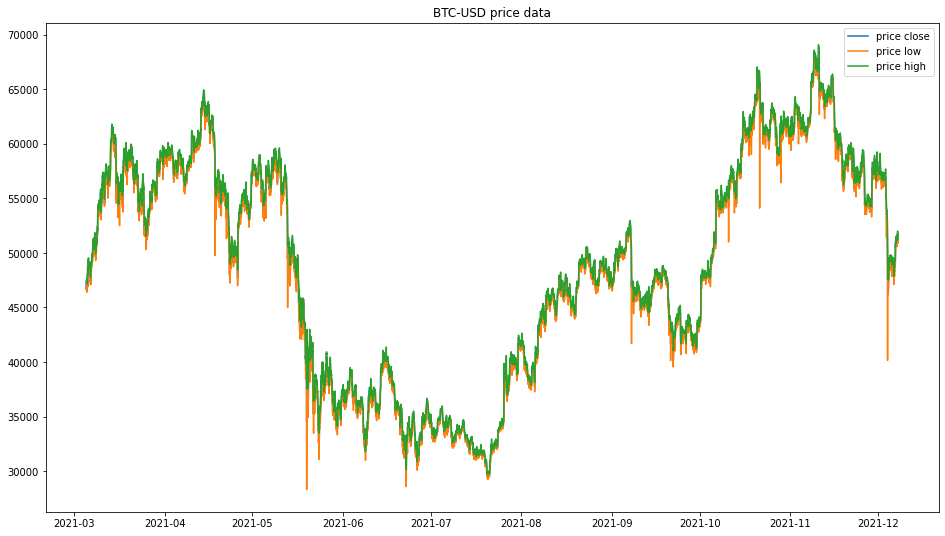

In [164]:
plt.figure(figsize = (16,9))
plt.plot(df['time_close'], df['price_close'], label='price close')
plt.plot(df['time_close'], df['price_low'], label='price low')
plt.plot(df['time_close'], df['price_high'], label='price high')
plt.title('BTC-USD price data')
plt.legend()

Text(0.5, 1.0, 'BTC-USD volume data')

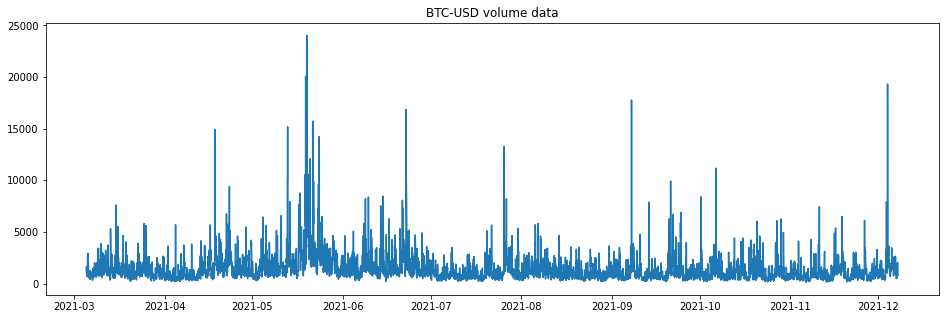

In [167]:
plt.figure(figsize = (16,5))
plt.plot(df['time_close'], df['volume_traded'])
plt.title('BTC-USD volume data')

### Preprocessing
The process of differencing is applied to target prices data to make the time series stationary. The models will be trained to make a single step prediction for the difference in close price between the last observation and the future unobserved value.

In [15]:
fe_df = df.copy()

In [16]:
for price in prices:
    fe_df[f'{price}_lag_1'] = fe_df[price].shift(1)
    fe_df[f'{price}_diff'] = fe_df[price] - fe_df[f'{price}_lag_1']
    fe_df.drop(f'{price}_lag_1', axis=1, inplace=True)

In [17]:
prices_diffs = list(map(lambda price: f'{price}_diff', prices))

No handles with labels found to put in legend.


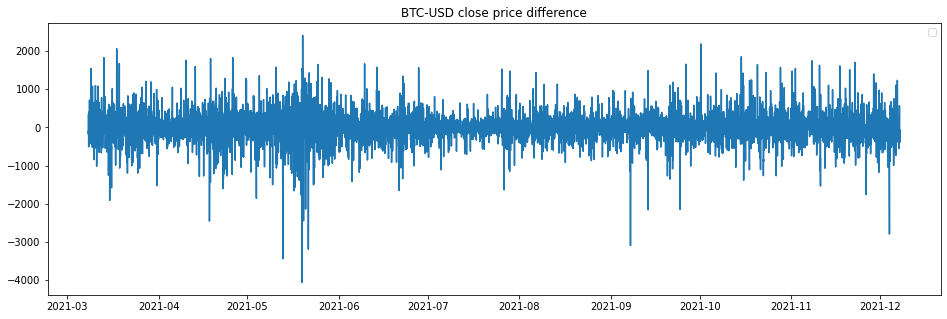

In [204]:
plt.figure(figsize = (16,5))
plt.plot(fe_df['time_close'], fe_df['price_close_diff'])
plt.title('BTC-USD close price difference')
plt.legend()

### Feature Engineering

In [19]:
fe_df['year'] = fe_df['time_close'].dt.year
fe_df['month'] = fe_df['time_close'].dt.month
fe_df['day'] = fe_df['time_close'].dt.day
fe_df['hour'] = fe_df['time_close'].dt.hour + 1
fe_df['day_of_week'] = fe_df['time_close'].dt.dayofweek

In [20]:
cal_features = [col for col in fe_df.columns if col not in df.columns]

Technical analysis features contain financial indicators categorized into momentum, volume, volatility, trend and other indicators. The first lag of the features is taken to fill the missing predictor values for the future timestamp.

In [21]:
fe_df = ta.add_all_ta_features(
    fe_df, 
    open='price_open', 
    close='price_close', 
    high='price_high', 
    low='price_low', 
    volume='volume_traded',
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [22]:
indicators = [col for col in fe_df.columns if col not in df.columns.tolist() + cal_features]

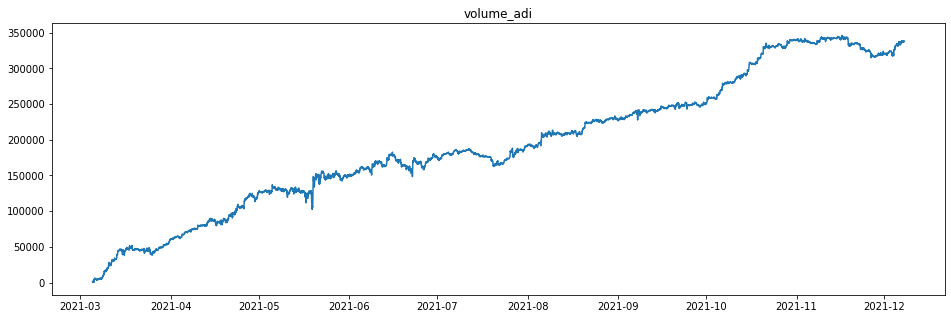

n NaNs: 0, last NaN: None


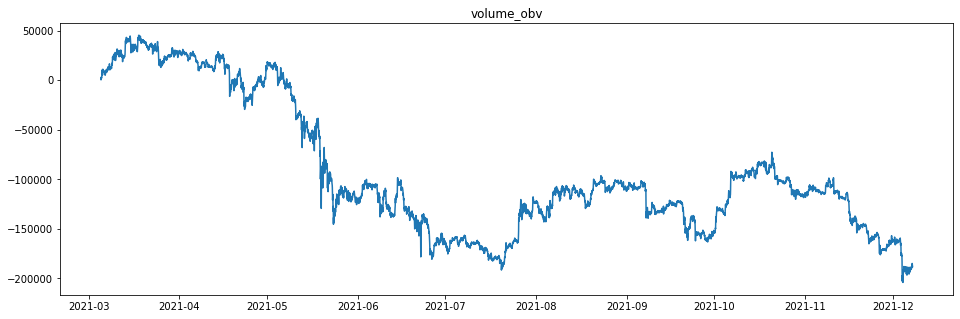

n NaNs: 0, last NaN: None


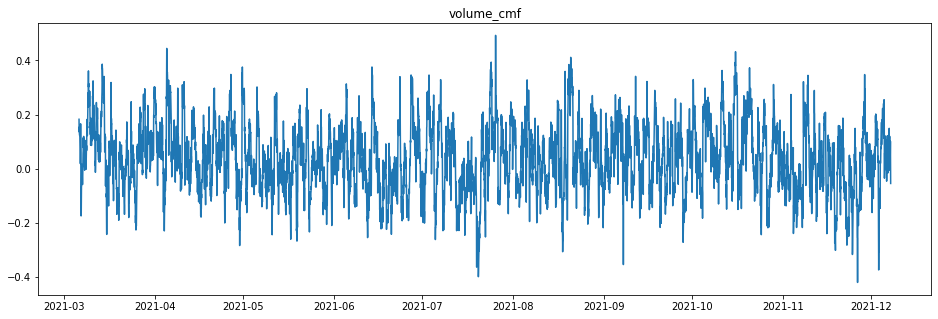

n NaNs: 19, last NaN: 18


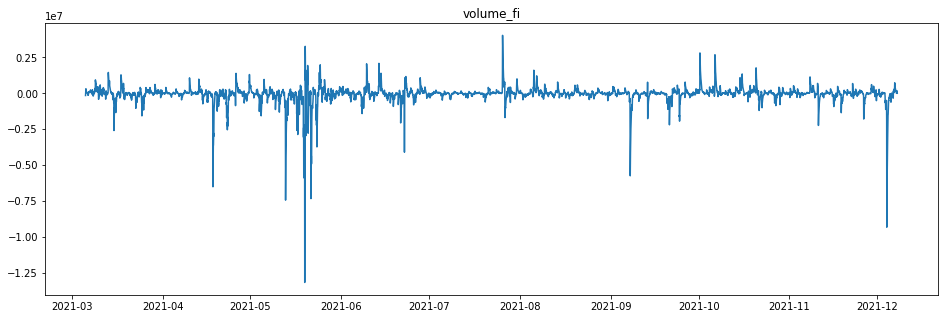

n NaNs: 13, last NaN: 12


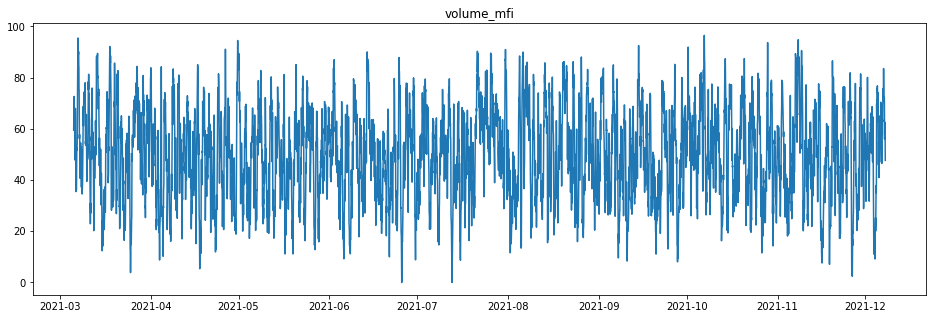

n NaNs: 13, last NaN: 12


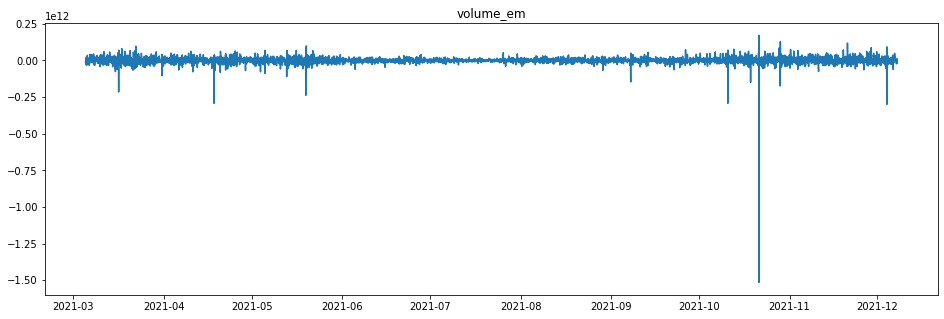

n NaNs: 1, last NaN: 0


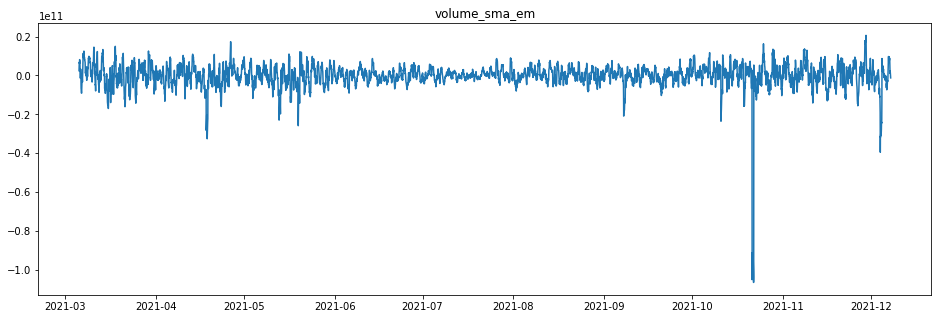

n NaNs: 14, last NaN: 13


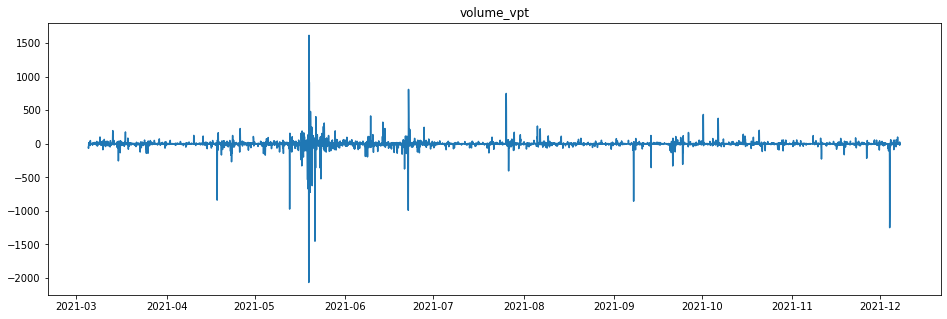

n NaNs: 0, last NaN: None


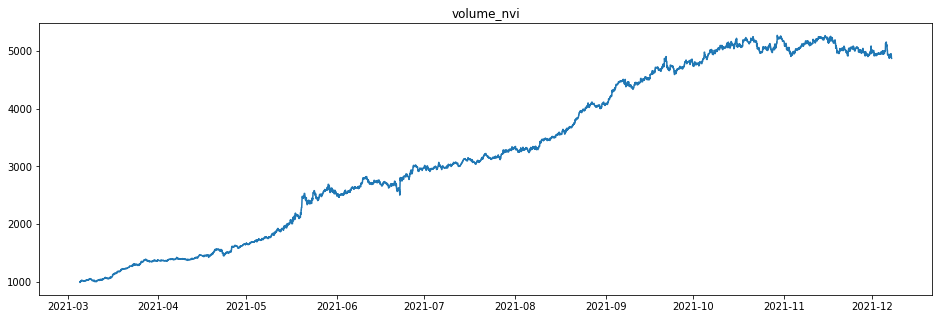

n NaNs: 0, last NaN: None


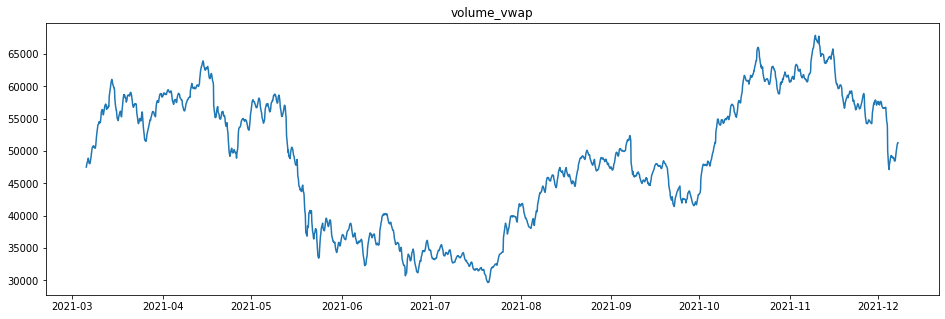

n NaNs: 13, last NaN: 12


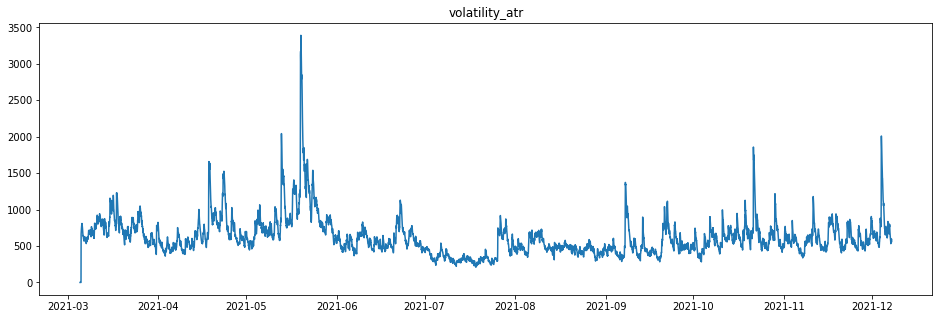

n NaNs: 0, last NaN: None


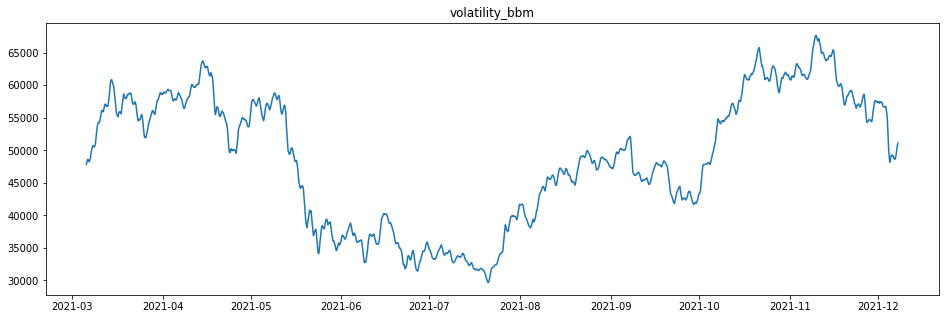

n NaNs: 19, last NaN: 18


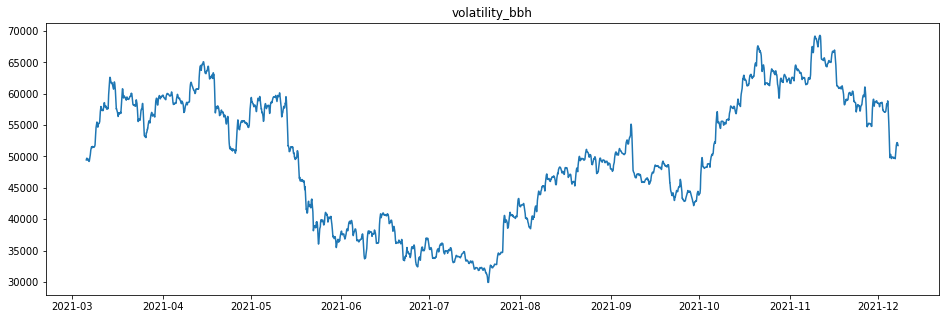

n NaNs: 19, last NaN: 18


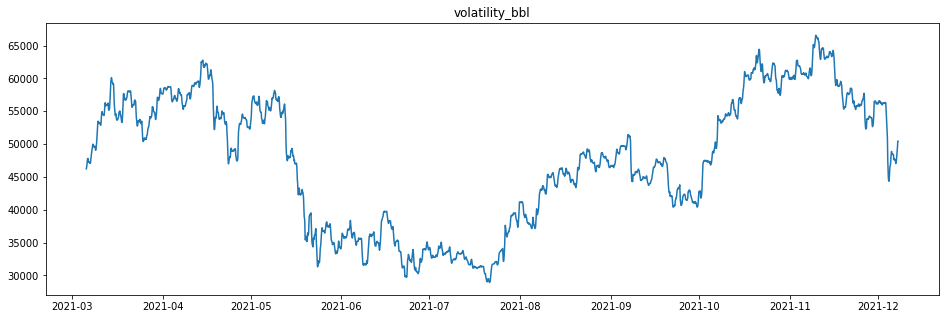

n NaNs: 19, last NaN: 18


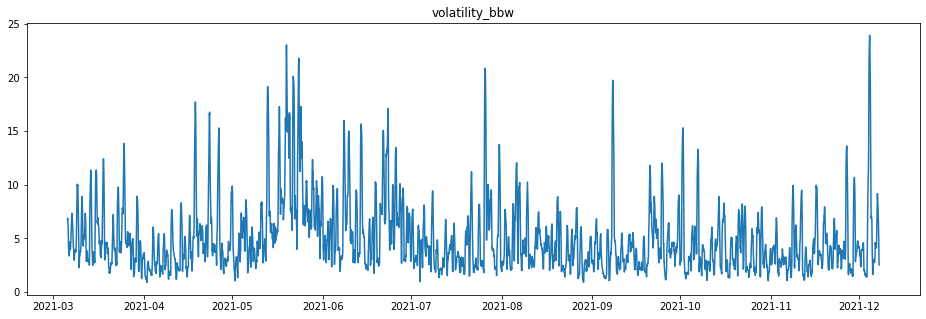

n NaNs: 19, last NaN: 18


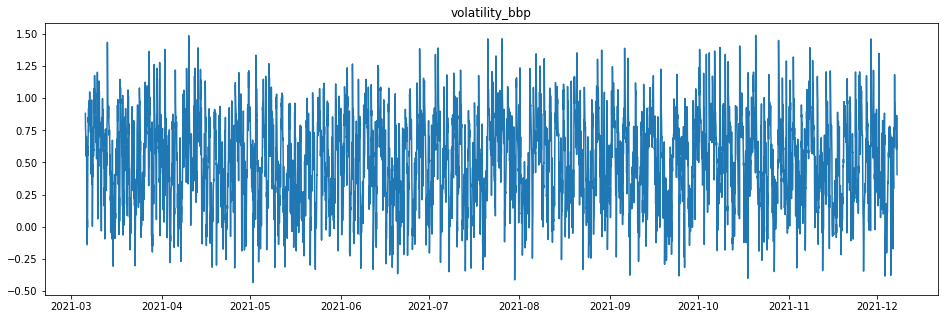

n NaNs: 19, last NaN: 18


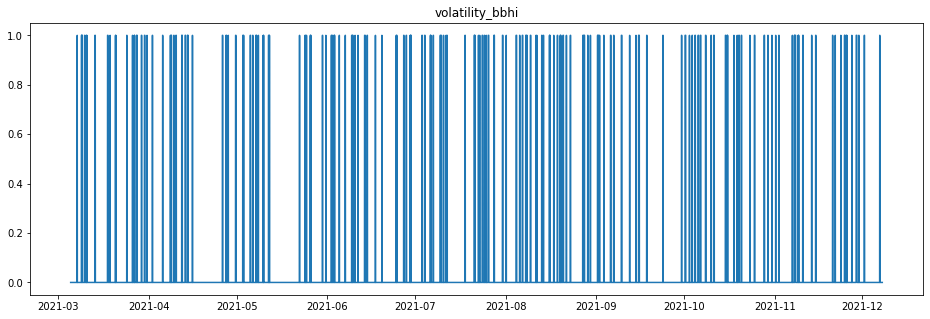

n NaNs: 0, last NaN: None


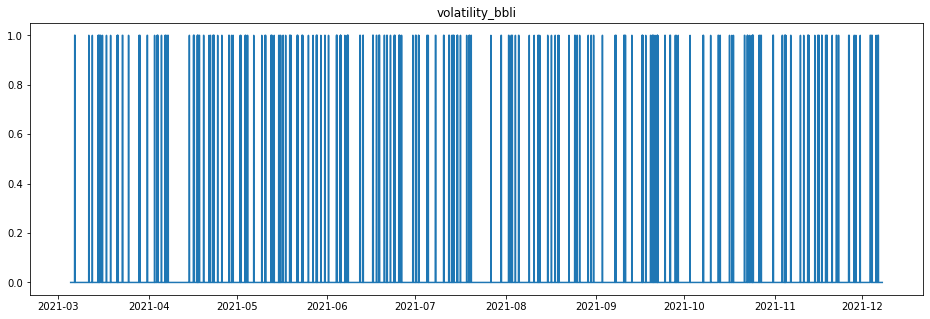

n NaNs: 0, last NaN: None


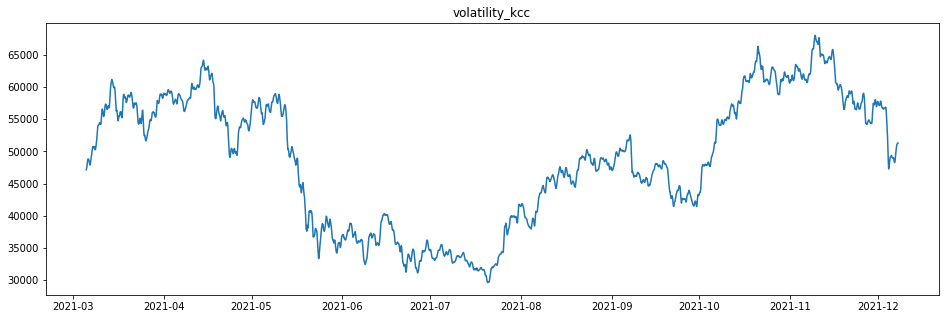

n NaNs: 9, last NaN: 8


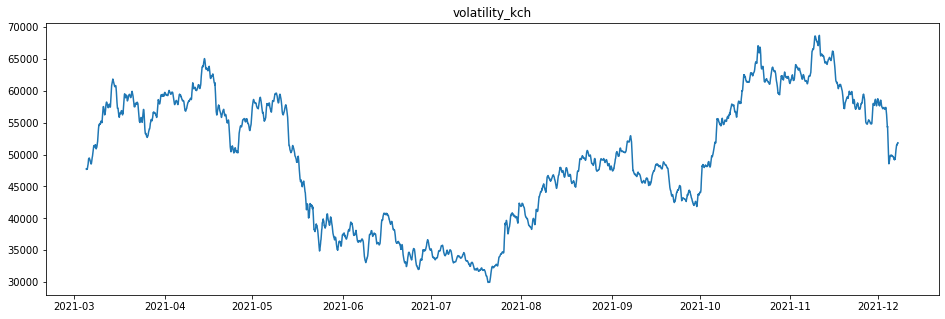

n NaNs: 0, last NaN: None


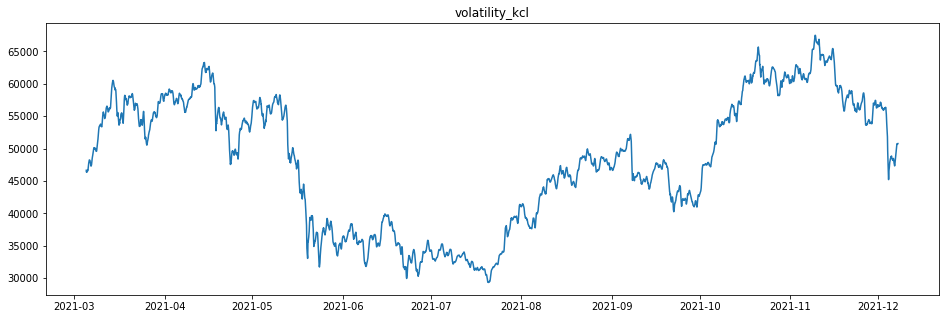

n NaNs: 0, last NaN: None


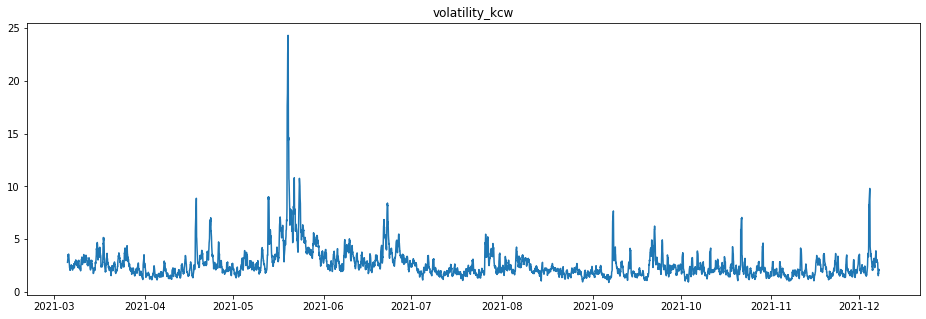

n NaNs: 9, last NaN: 8


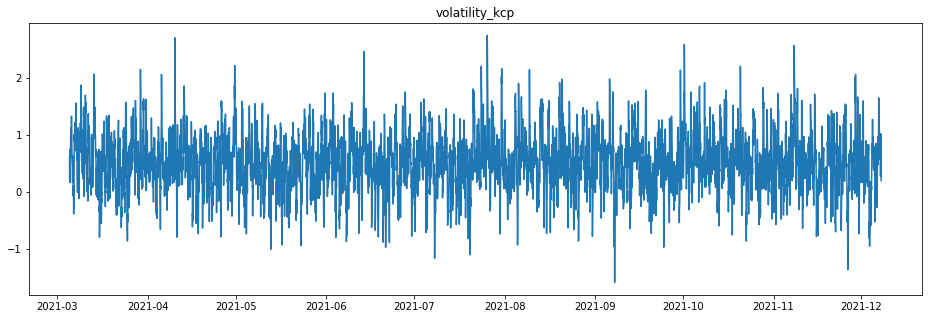

n NaNs: 0, last NaN: None


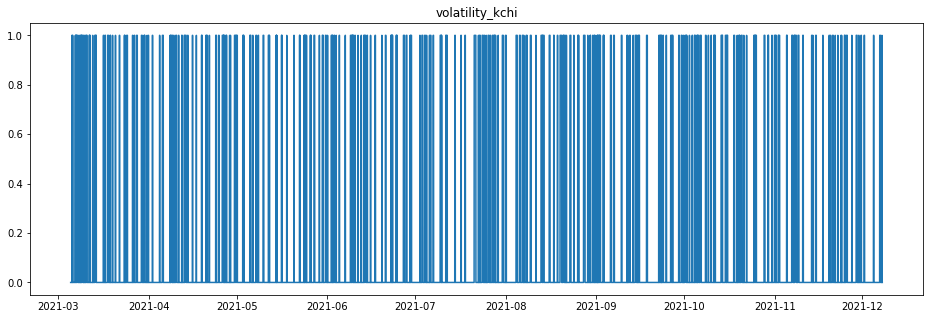

n NaNs: 0, last NaN: None


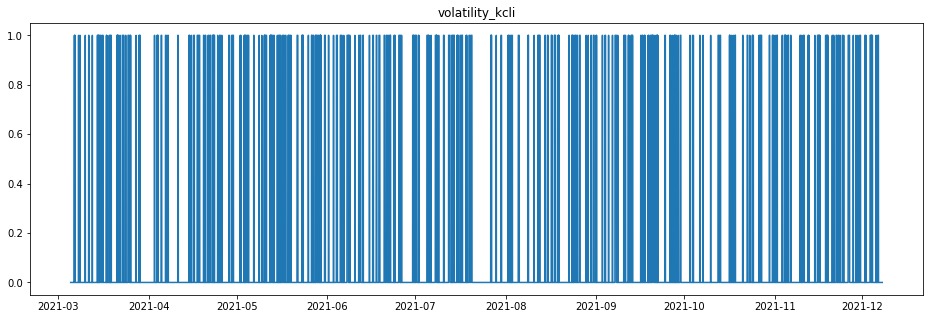

n NaNs: 0, last NaN: None


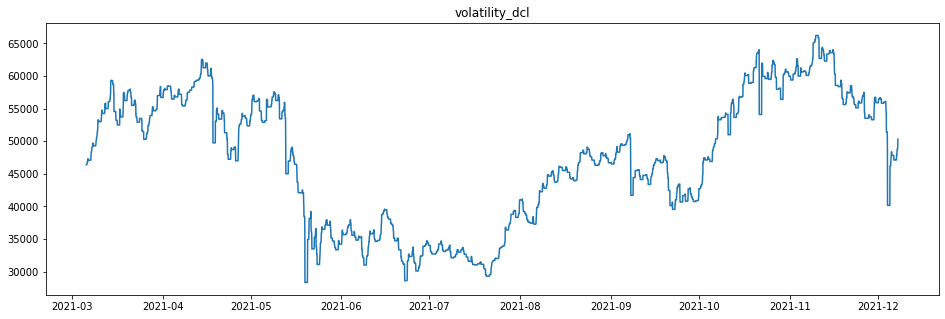

n NaNs: 19, last NaN: 18


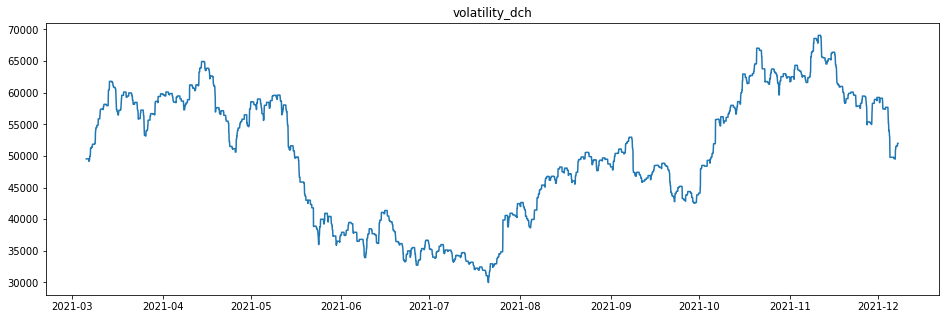

n NaNs: 19, last NaN: 18


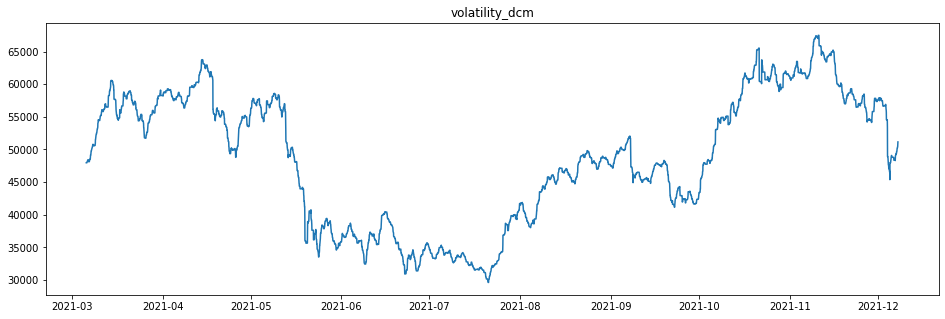

n NaNs: 19, last NaN: 18


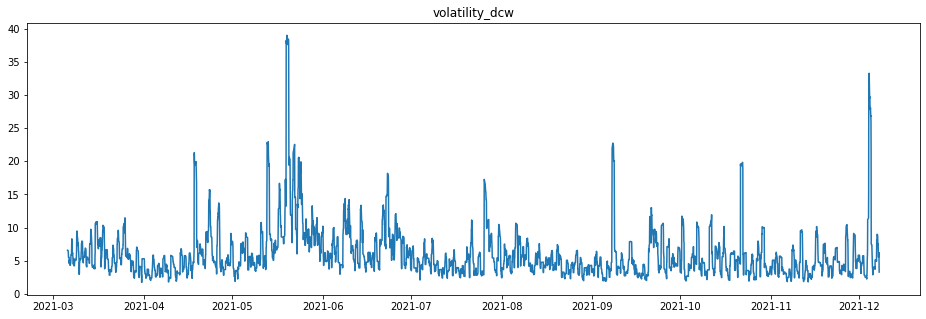

n NaNs: 19, last NaN: 18


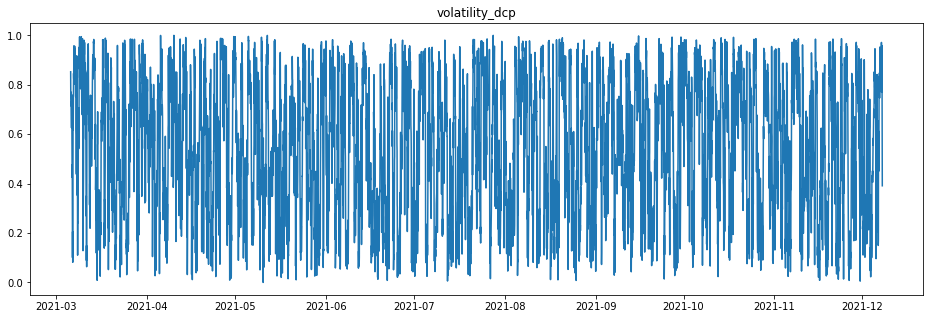

n NaNs: 19, last NaN: 18


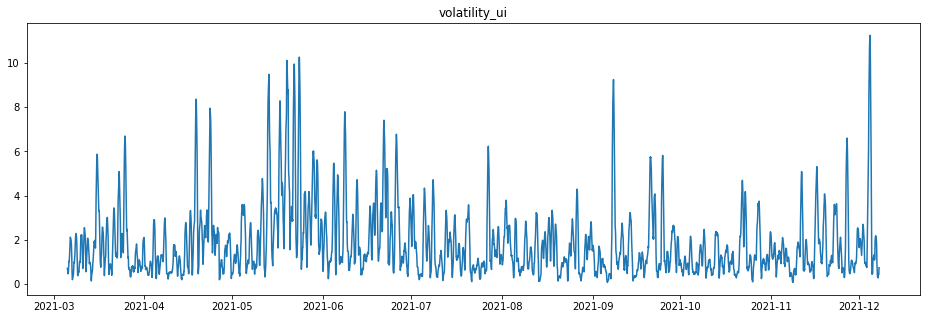

n NaNs: 13, last NaN: 12


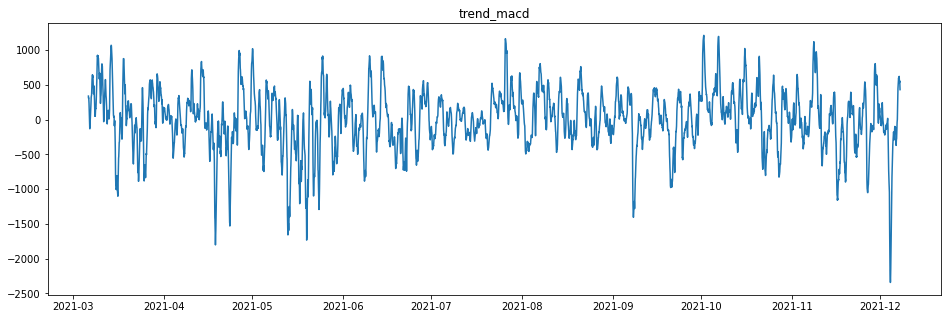

n NaNs: 25, last NaN: 24


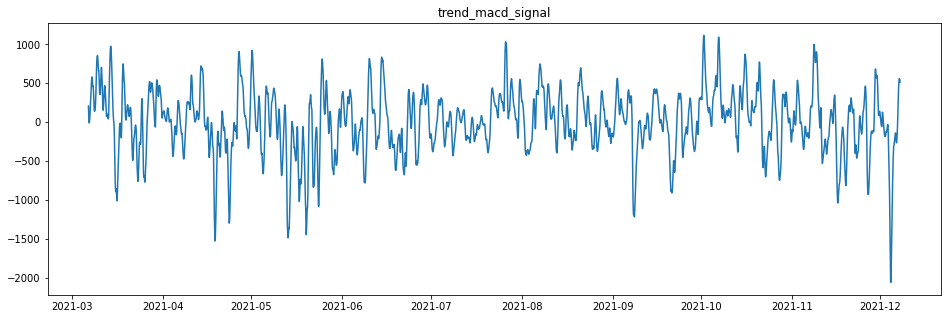

n NaNs: 33, last NaN: 32


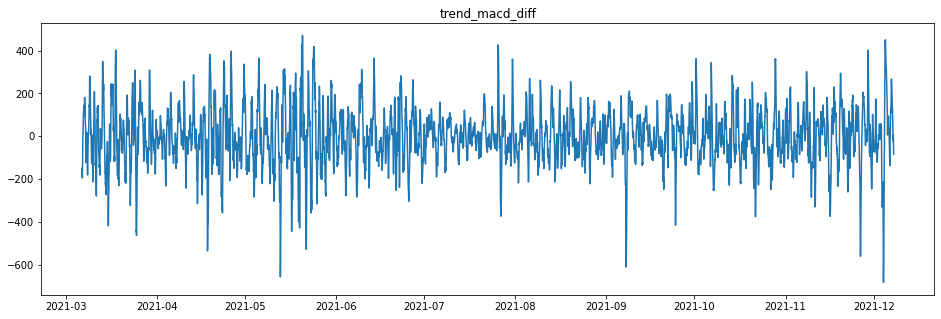

n NaNs: 33, last NaN: 32


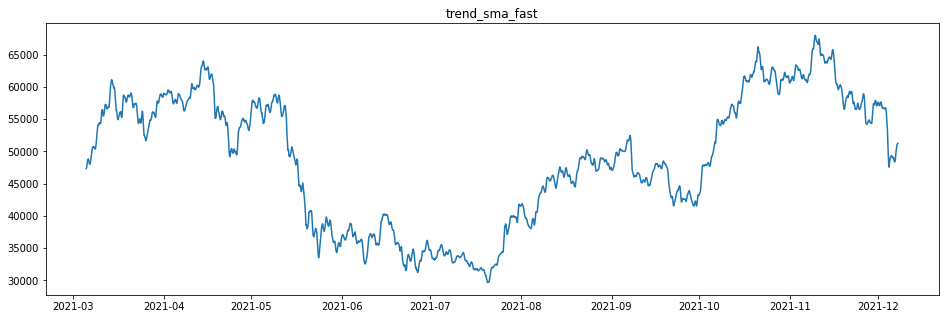

n NaNs: 11, last NaN: 10


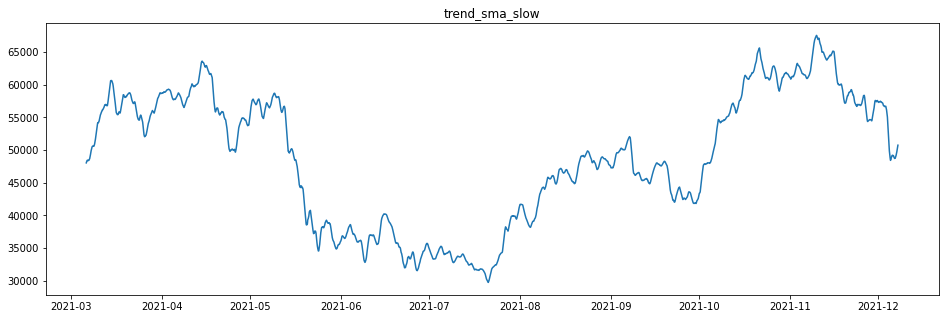

n NaNs: 25, last NaN: 24


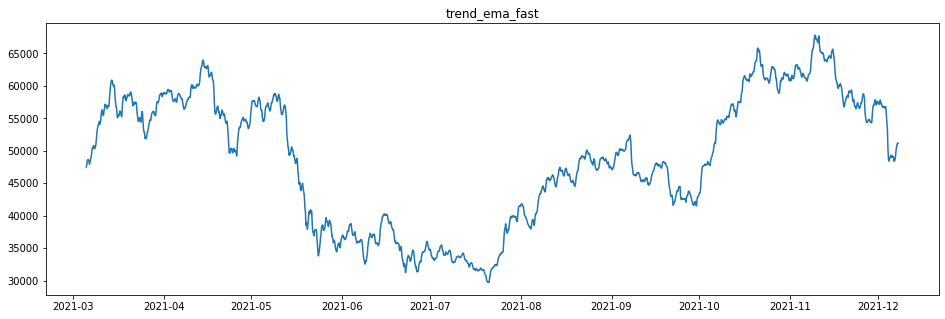

n NaNs: 11, last NaN: 10


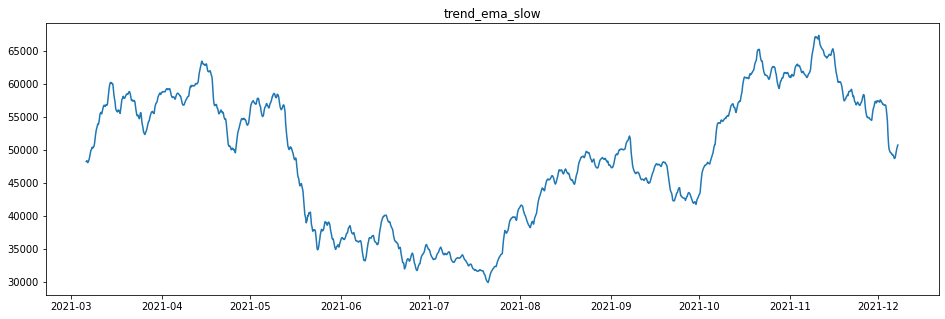

n NaNs: 25, last NaN: 24


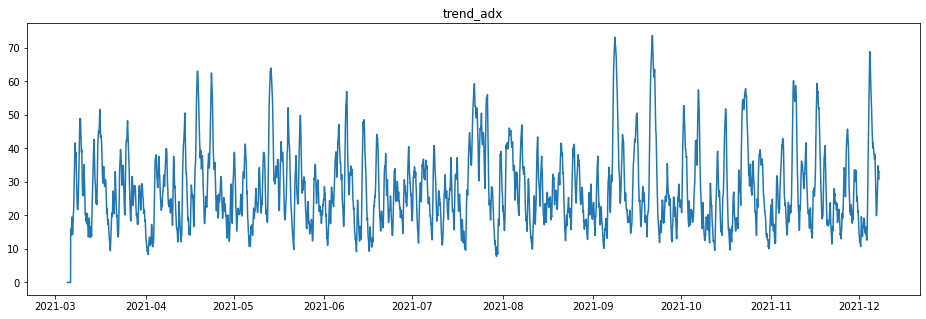

n NaNs: 0, last NaN: None


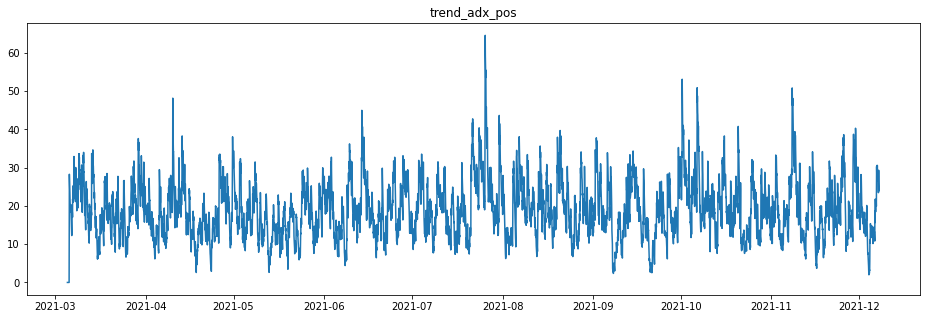

n NaNs: 0, last NaN: None


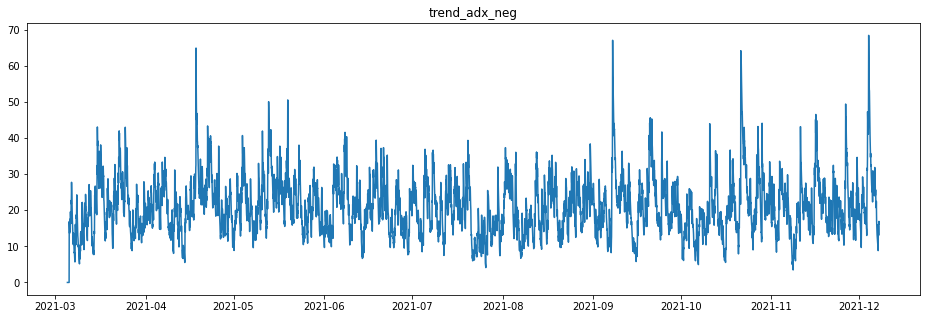

n NaNs: 0, last NaN: None


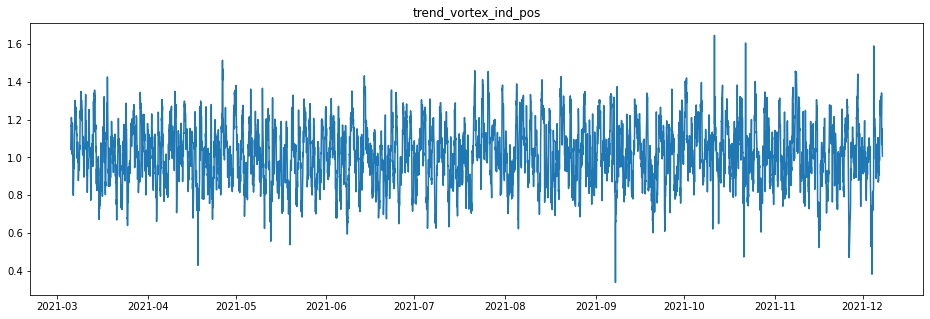

n NaNs: 14, last NaN: 13


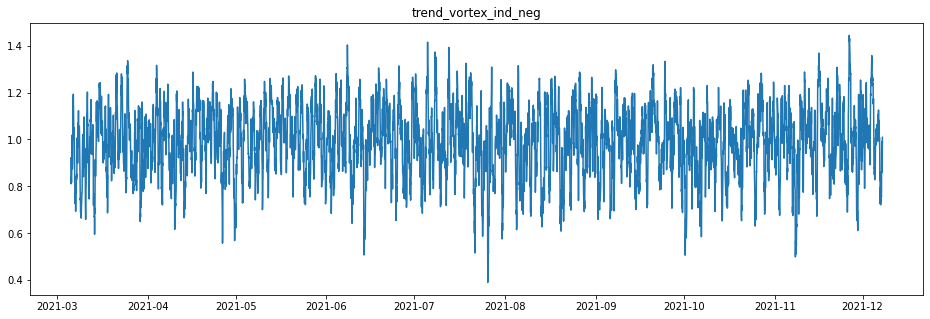

n NaNs: 14, last NaN: 13


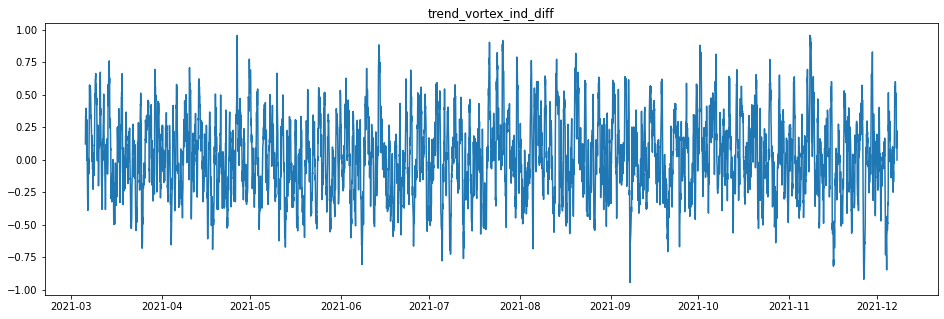

n NaNs: 14, last NaN: 13


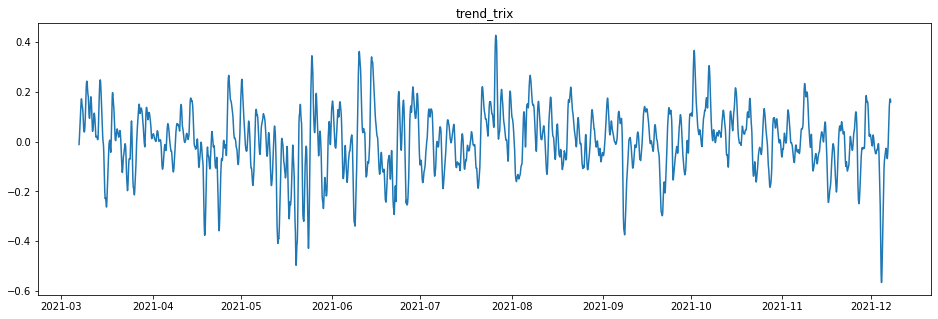

n NaNs: 43, last NaN: 42


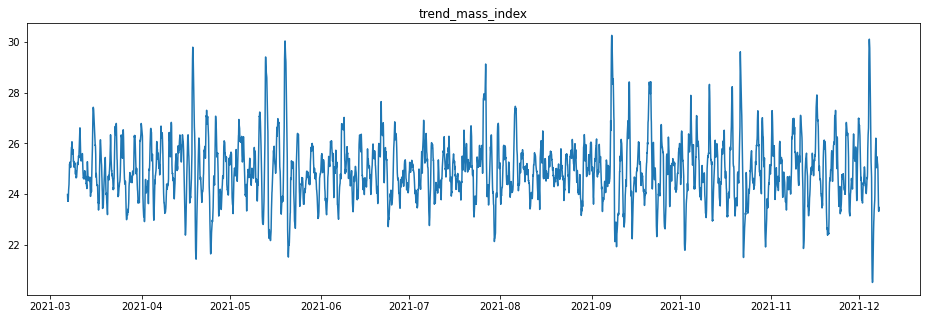

n NaNs: 40, last NaN: 39


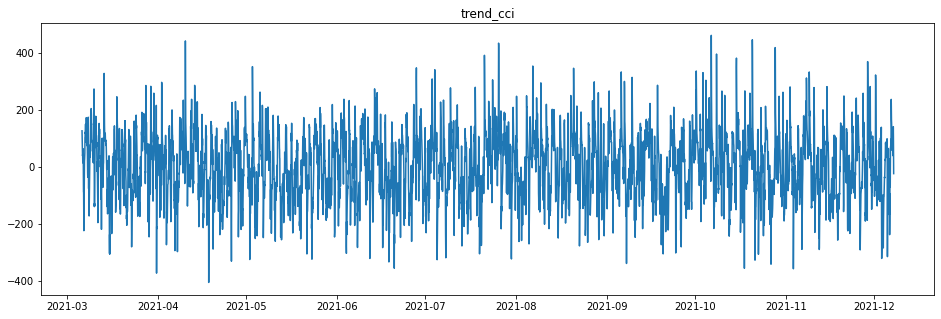

n NaNs: 19, last NaN: 18


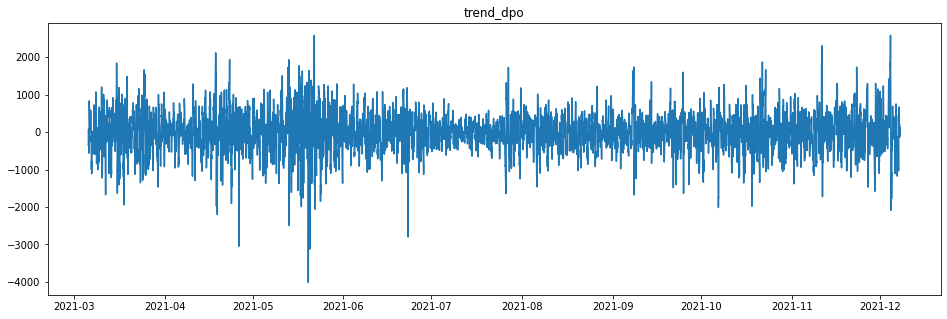

n NaNs: 19, last NaN: 18


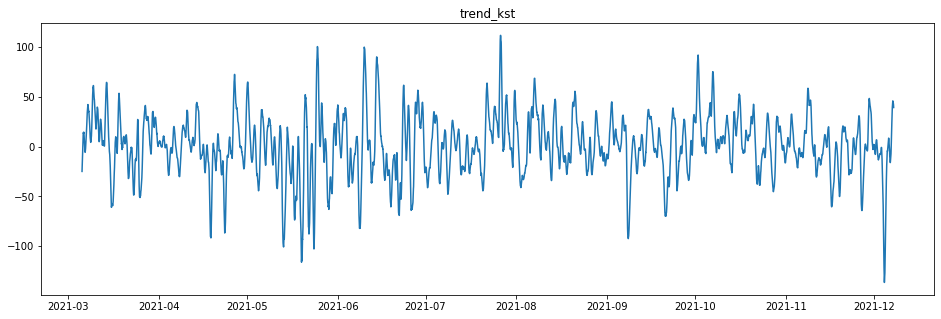

n NaNs: 14, last NaN: 13


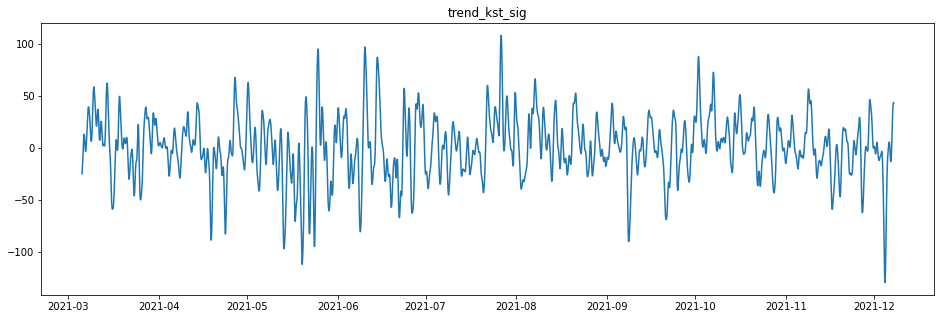

n NaNs: 14, last NaN: 13


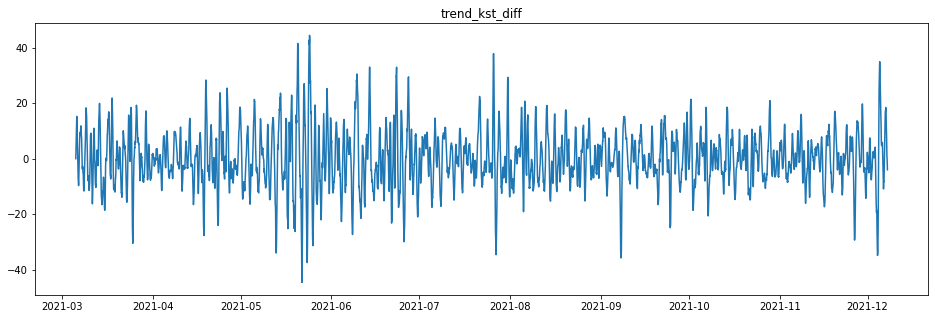

n NaNs: 14, last NaN: 13


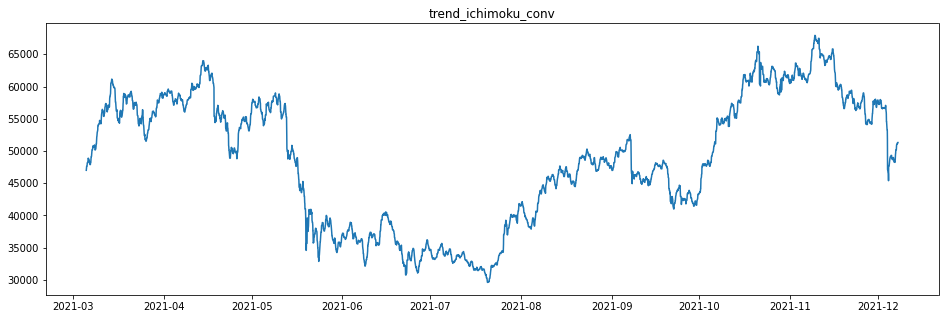

n NaNs: 8, last NaN: 7


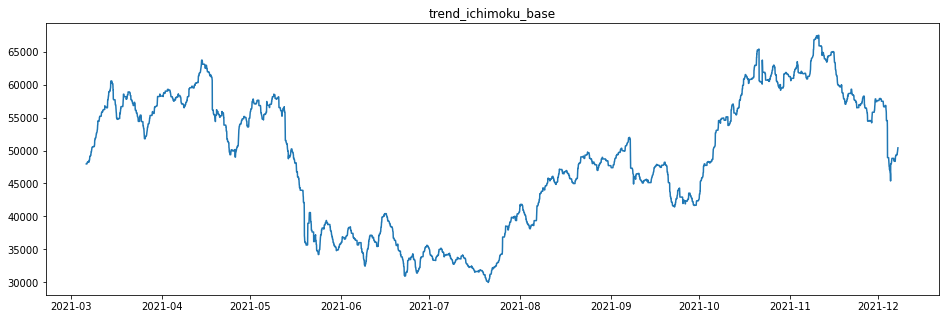

n NaNs: 25, last NaN: 24


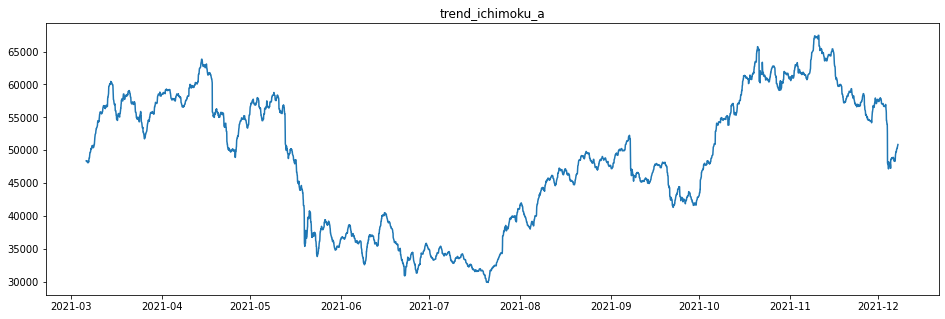

n NaNs: 25, last NaN: 24


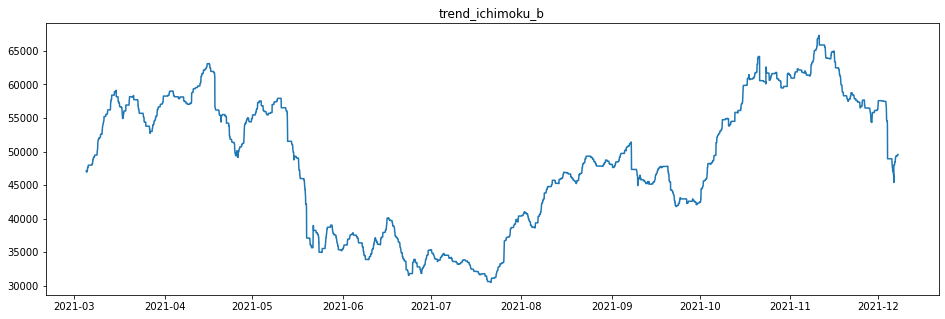

n NaNs: 0, last NaN: None


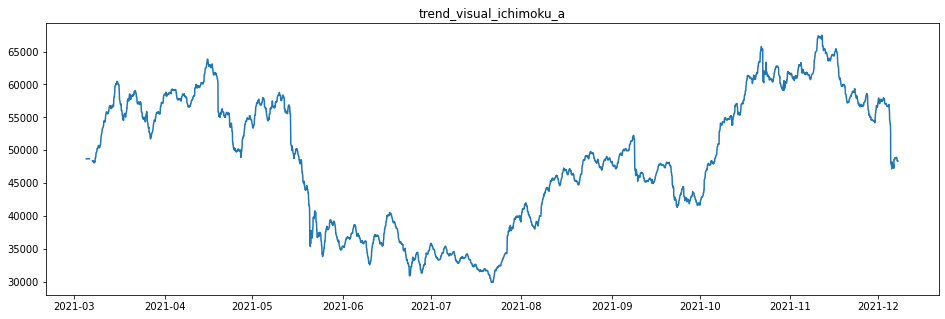

n NaNs: 25, last NaN: 50


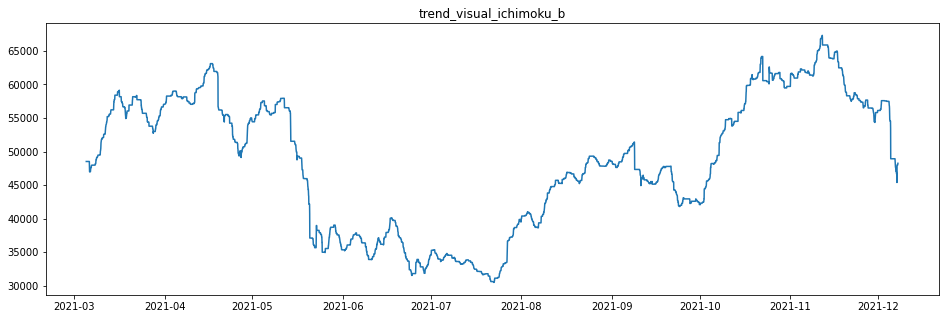

n NaNs: 0, last NaN: None


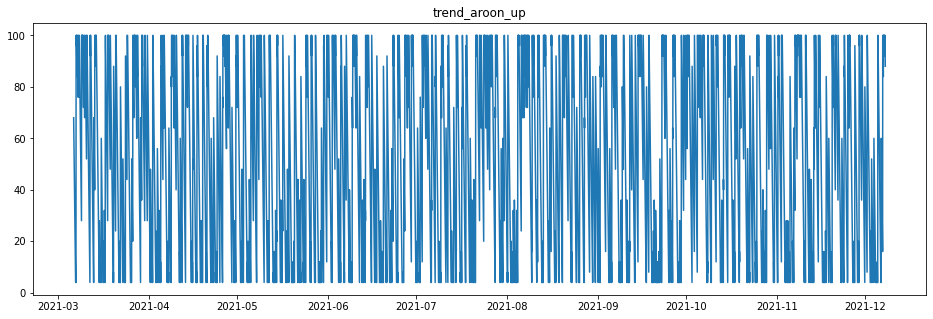

n NaNs: 24, last NaN: 23


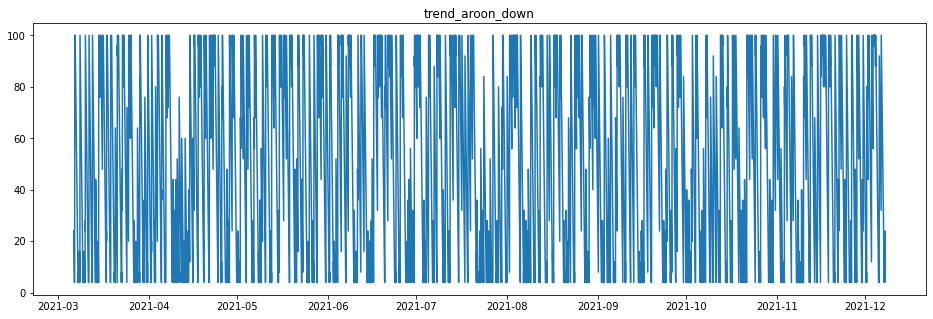

n NaNs: 24, last NaN: 23


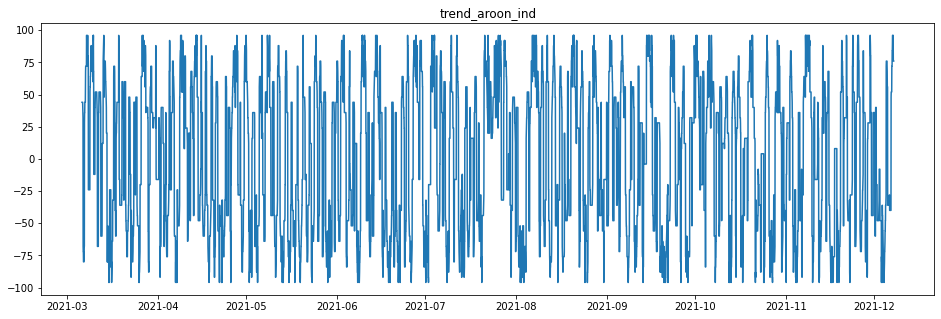

n NaNs: 24, last NaN: 23


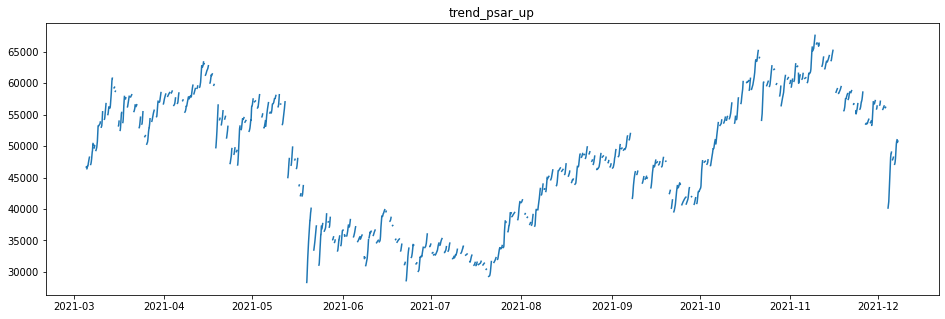

n NaNs: 3149, last NaN: 6658


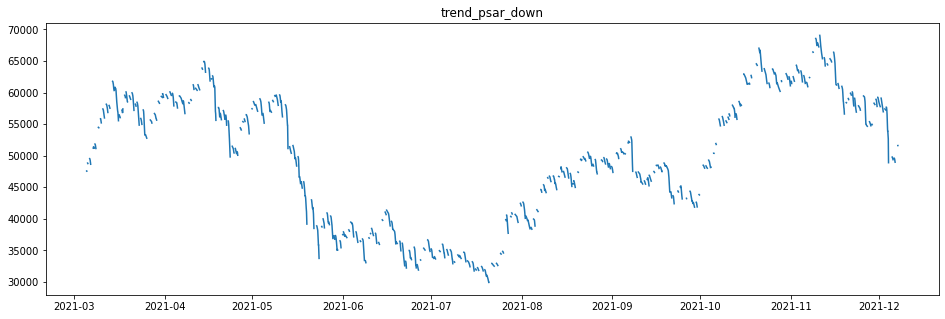

n NaNs: 3517, last NaN: 6663


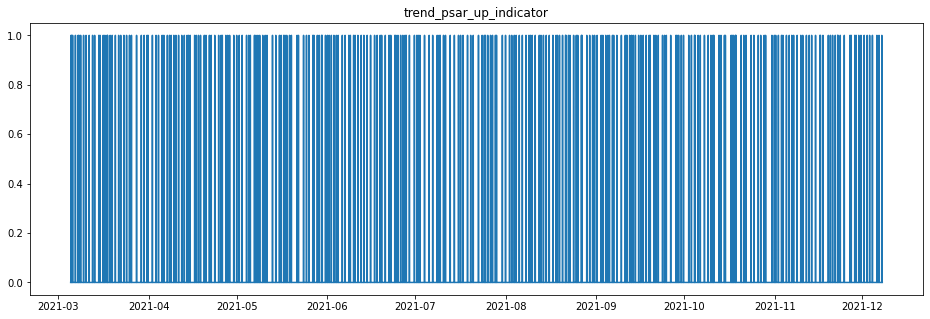

n NaNs: 0, last NaN: None


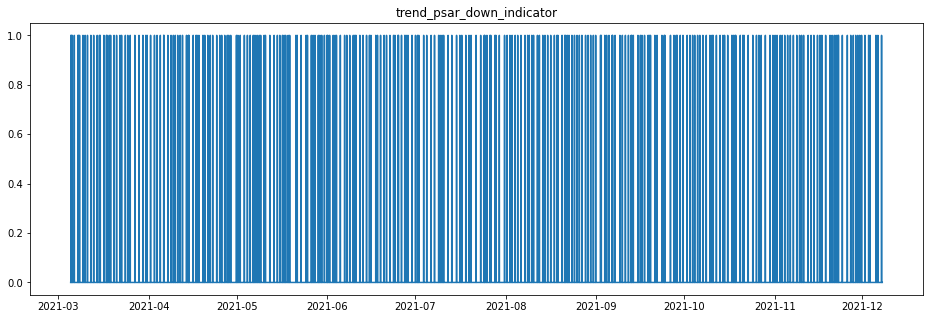

n NaNs: 0, last NaN: None


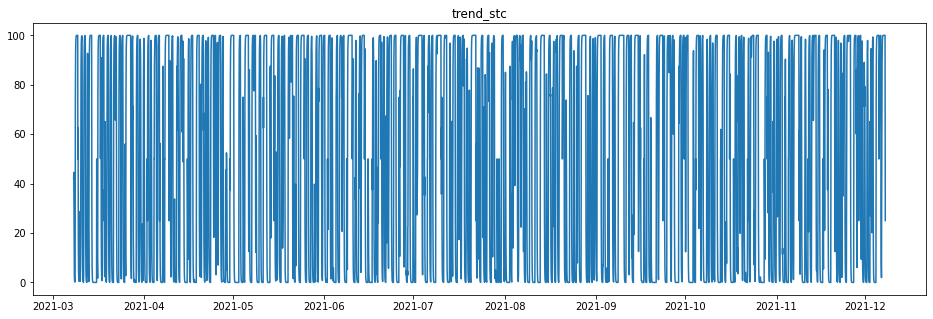

n NaNs: 71, last NaN: 70


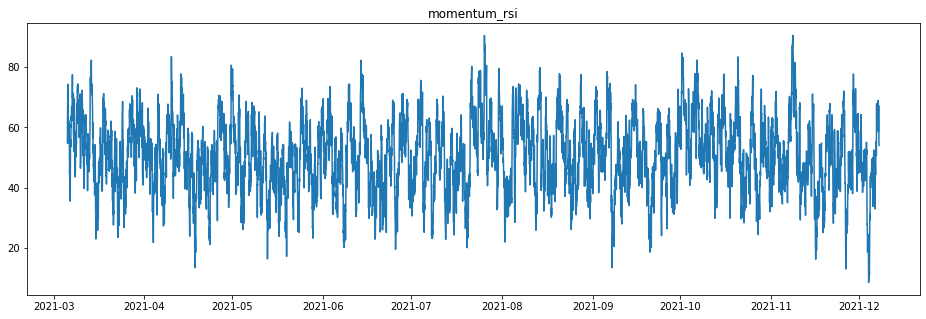

n NaNs: 13, last NaN: 12


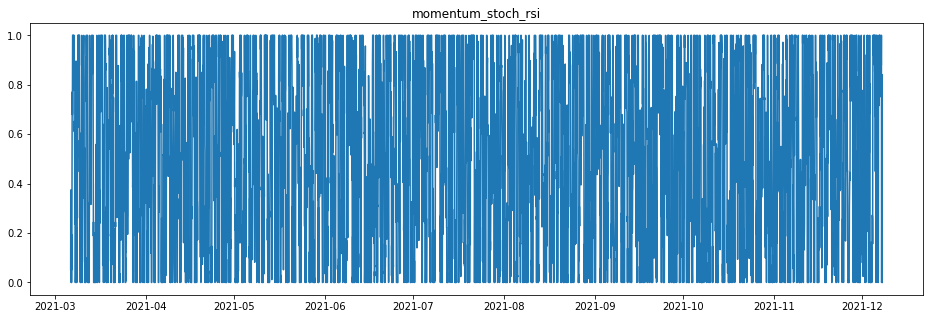

n NaNs: 26, last NaN: 25


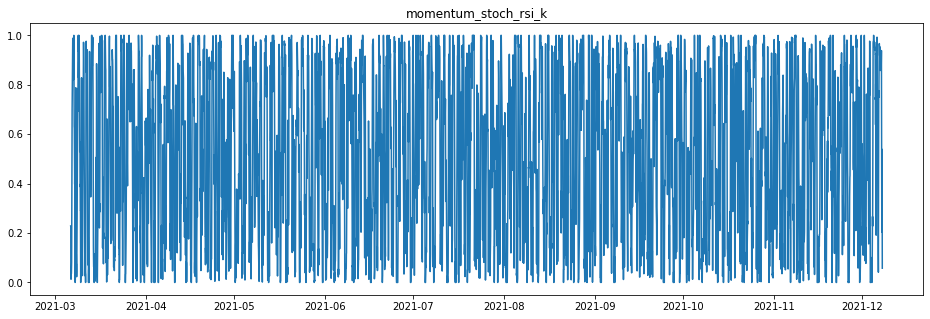

n NaNs: 28, last NaN: 27


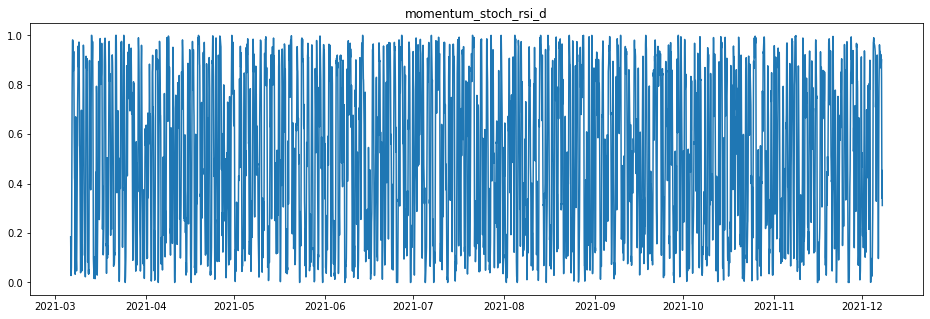

n NaNs: 30, last NaN: 29


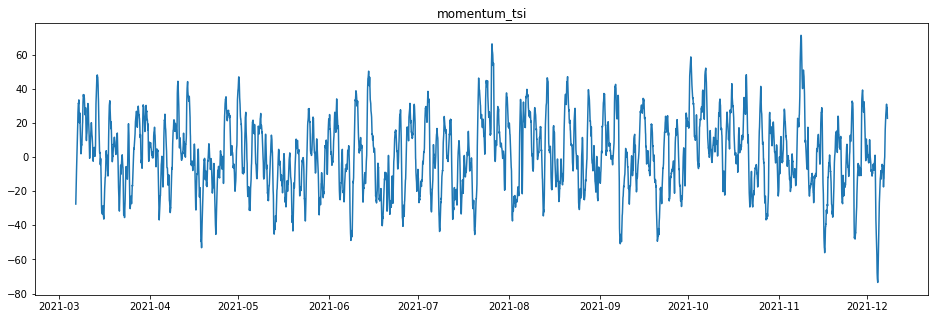

n NaNs: 37, last NaN: 36


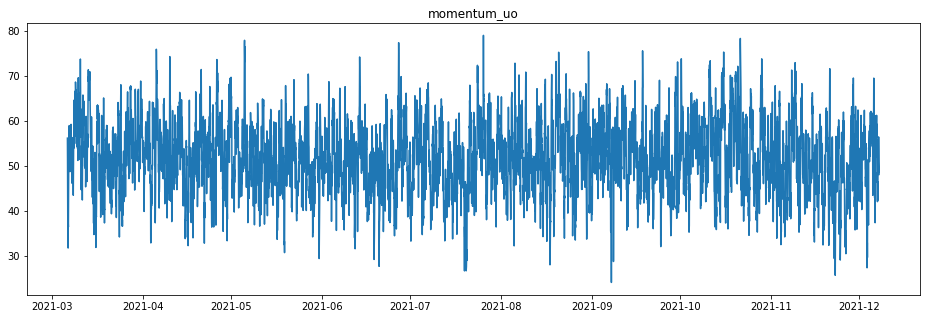

n NaNs: 28, last NaN: 27


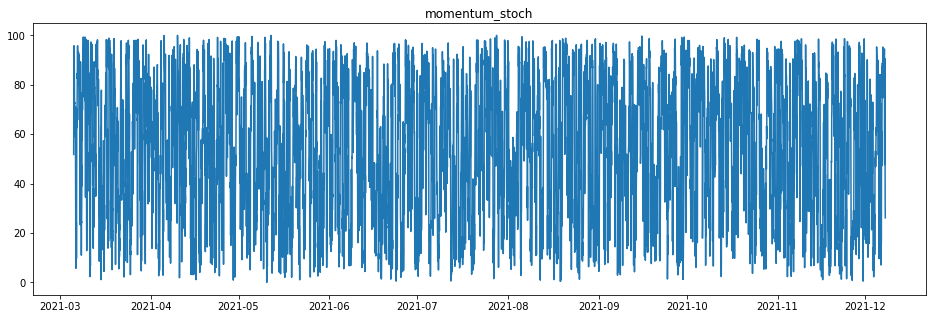

n NaNs: 13, last NaN: 12


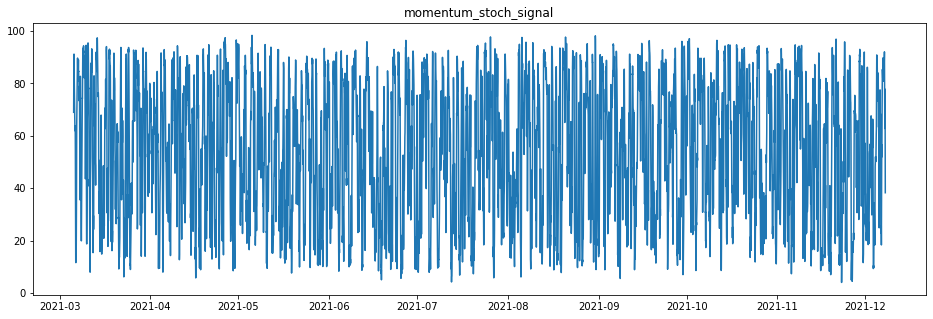

n NaNs: 15, last NaN: 14


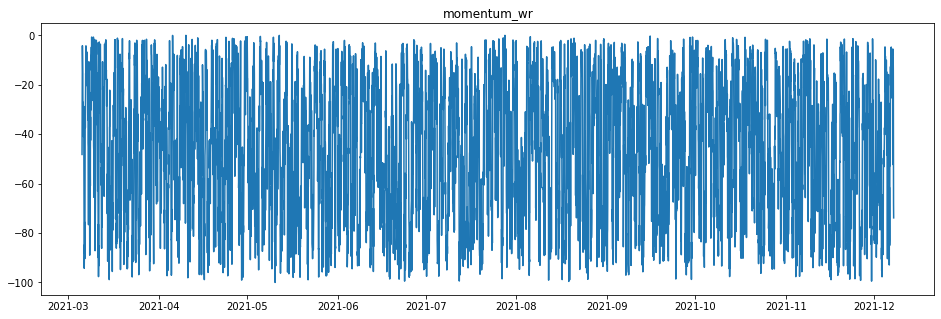

n NaNs: 13, last NaN: 12


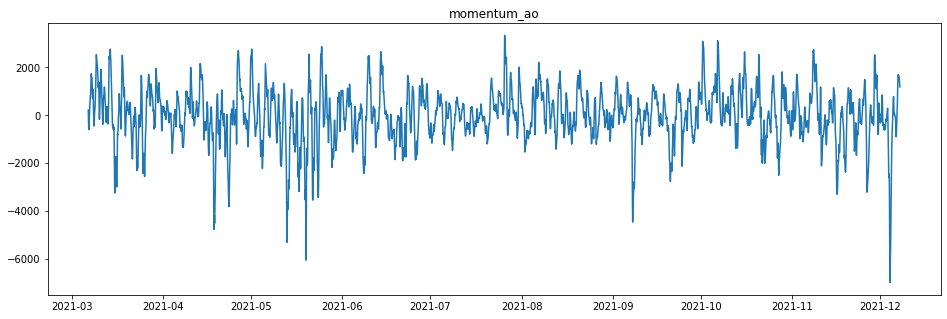

n NaNs: 33, last NaN: 32


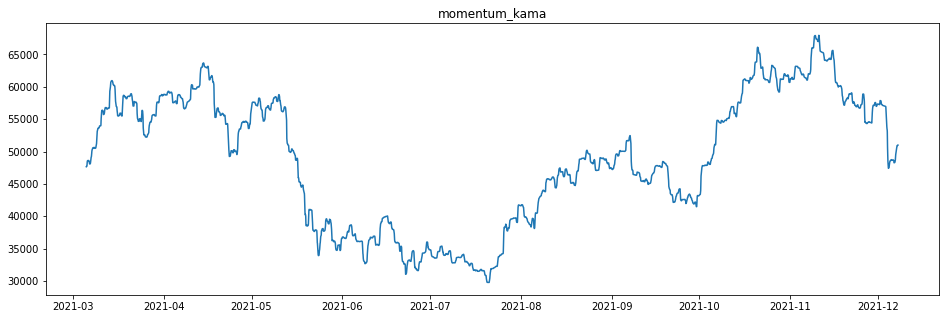

n NaNs: 9, last NaN: 8


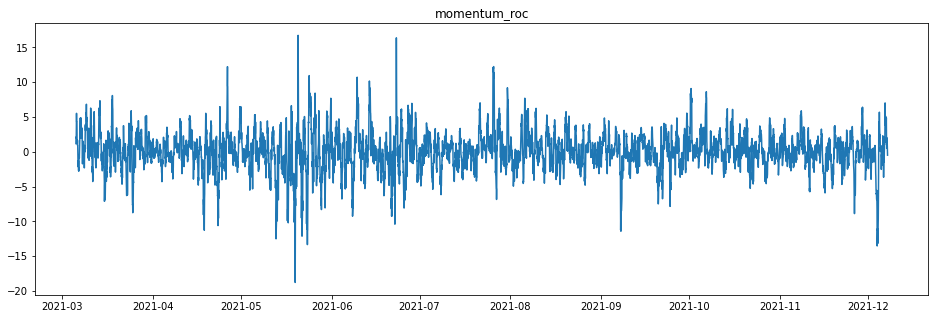

n NaNs: 12, last NaN: 11


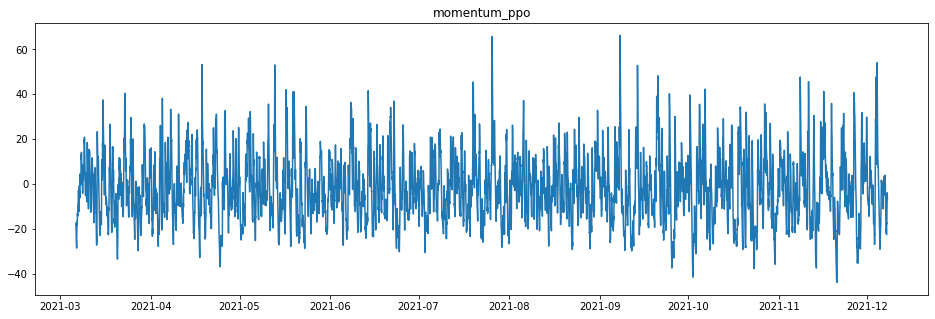

n NaNs: 25, last NaN: 24


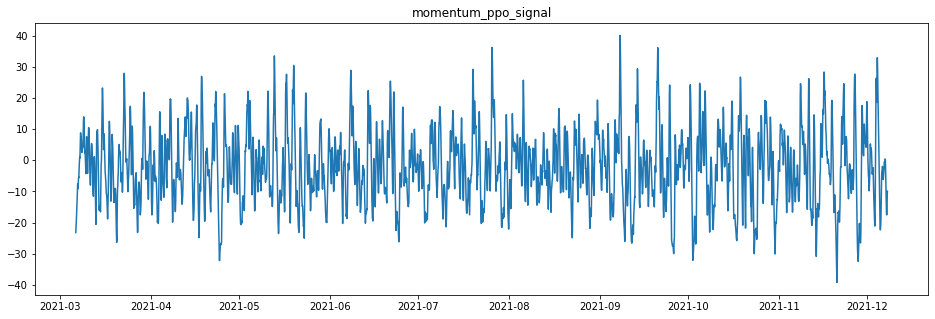

n NaNs: 33, last NaN: 32


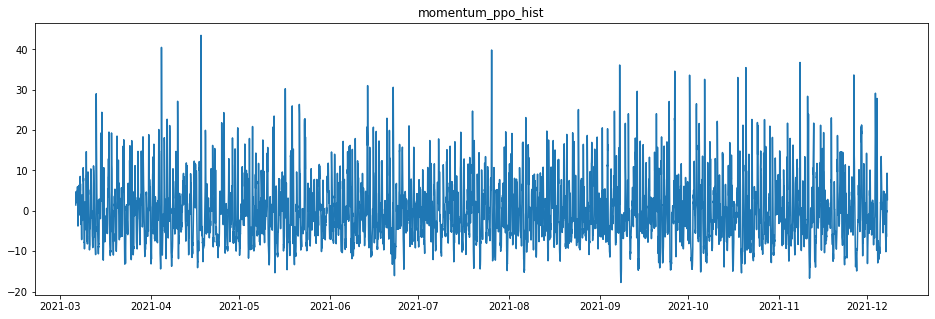

n NaNs: 33, last NaN: 32


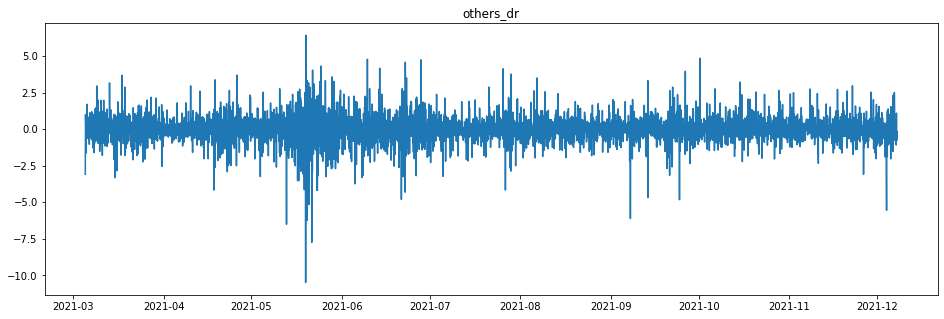

n NaNs: 0, last NaN: None


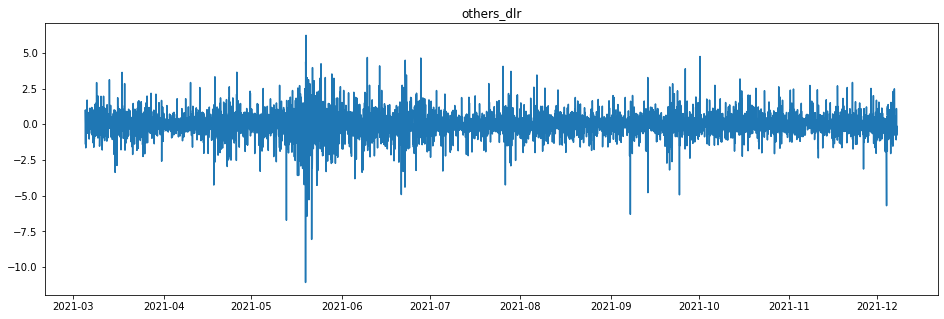

n NaNs: 1, last NaN: 0


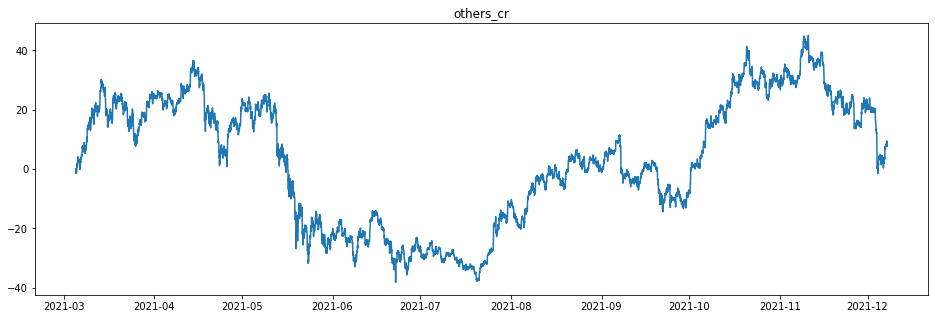

n NaNs: 0, last NaN: None


In [23]:
for indicator in indicators:
    plt.figure(figsize = (16,5))
    plt.title(indicator)
    plt.plot(fe_df['time_close'], fe_df[indicator])
    plt.show()
    print(f'n NaNs: {fe_df[indicator].isna().sum()}, last NaN: {fe_df[indicator].isna().where(lambda x : x).last_valid_index()}')

In [24]:
exclude_threshold_idx = 100
exclude_indicators = [ind for ind in indicators if int(fe_df[ind].isna().where(lambda x : x).last_valid_index() or 0) > exclude_threshold_idx]
indicators = [ind for ind in indicators if ind not in exclude_indicators]

In [25]:
fe_df.drop(exclude_indicators, axis=1, inplace=True)

In [26]:
for indicator in indicators:
    fe_df[indicator] = fe_df[indicator].shift(1)

Lags and moving average features are added for the prices and volume.

In [28]:
lags = [l for l in range(1, 10)]

for l, target in product(lags, prices_diffs + ['volume_traded']):
    fe_df[f'{target}_lag_{l}'] = fe_df[target].shift(l)

In [29]:
windows = [w for w in range(2, 10)]

for w, target in product(windows, prices_diffs + ['volume_traded']):
    fe_df[f'{target}_mean_w_{w}_lagged'] = fe_df[target].rolling(window=w).mean().shift(1)

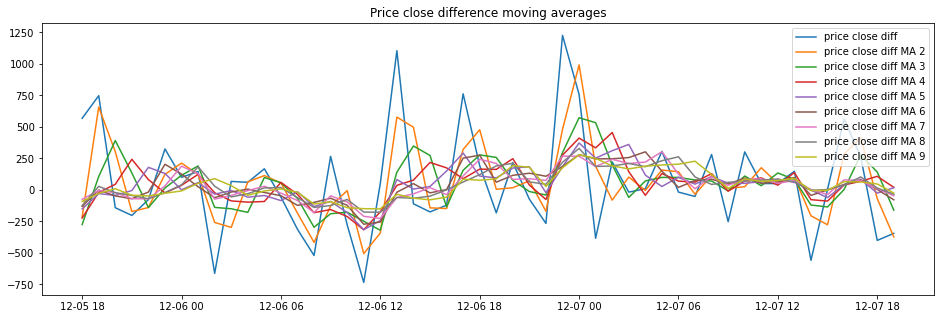

In [168]:
plt.figure(figsize = (16,5))
plt.plot(fe_df['time_close'][-50:], fe_df['price_close_diff'].shift(1)[-50:], label='price close diff')
for w in windows:
    plt.plot(fe_df['time_close'][-50:], fe_df[f'price_close_diff_mean_w_{w}_lagged'][-50:], label=f'price close diff MA {w}')
plt.title('Price close difference moving averages')
plt.legend()

In [31]:
fe_df.dropna(inplace=True)
fe_df.reset_index(inplace=True, drop=True)

In [32]:
fe_df['price_close_diff_direction'] = np.sign(fe_df['price_close_diff']).astype('int32') 

In [33]:
X_cols = [col for col in fe_df.columns if col not in list(df.columns) + prices_diffs + ['price_close_diff_direction']]
ts_cols = [col for col in X_cols if col not in cal_features]
y_col = 'price_close_diff'
y_col_class = 'price_close_diff_direction'

The data is split into train and test sets such that the test set contains the last 2000 observations.

In [34]:
X = fe_df[X_cols][:fe_df.shape[0]-end_offset]
y = fe_df[y_col][:fe_df.shape[0]-end_offset]
y_class = fe_df[y_col_class][:fe_df.shape[0]-end_offset]

X_trn, y_trn = X[:-pred_window], y[:-pred_window]
X_tst, y_tst = X[-pred_window:], y[-pred_window:]
y_class_trn = y_class[:-pred_window]
y_class_tst = y_class[-pred_window:]

In [35]:
X

year  month  day  hour  day_of_week     volume_adi     volume_obv  \
0     2021      3    8     4            0    5399.515937   14695.102931   
1     2021      3    8     5            0    5822.682373   13296.764906   
2     2021      3    8     6            0    6053.472033   12570.392073   
3     2021      3    8     7            0    6541.280969   13258.689052   
4     2021      3    8     8            0    5805.153701   12249.997216   
...    ...    ...  ...   ...          ...            ...            ...   
6587  2021     12    7    15            1  337165.683899 -188398.837625   
6588  2021     12    7    16            1  338247.206765 -186854.384677   
6589  2021     12    7    17            1  338917.940578 -184826.349568   
6590  2021     12    7    18            1  338471.128184 -186116.053897   
6591  2021     12    7    19            1  338042.511803 -187189.235673   

      volume_cmf      volume_fi  volume_mfi  ...  \
0       0.040565  -14922.395306   51.848617  ...   
1       0.035005  -34962.272744   46.111452  ...   
2       0.059201  -47994.160733   48.448193  ...   
3       0.058880   -6867.545426   52.794624  ...   
4       0.036631  -79561.319267   45.039676  ...   
...          ...            ...         ...  ...   
6587    0.026639    5452.736406   60.086693  ...   
6588    0.028599  128962.521896   61.589976  ...   
6589    0.091997  187138.190558   62.576178  ...   
6590    0.101484   86631.233261   60.473295  ...   
6591    0.041905   21411.872152   53.376261  ...   

      price_open_diff_mean_w_8_lagged  price_close_diff_mean_w_8_lagged  \
0                            64.98750                          44.49375   
1                            43.97875                          33.26875   
2                            32.18625                          50.93375   
3                            51.63875                          89.46500   
4                            88.54750                         -25.13125   
...                               ...                               ...   
6587                         -2.35125                           3.63375   
6588                          4.28250                          38.87750   
6589                         39.18750                         103.37875   
6590                        103.71125                          15.56750   
6591                         15.33750                         -33.85750   

      price_high_diff_mean_w_8_lagged  price_low_diff_mean_w_8_lagged  \
0                            62.33250                        20.87375   
1                            33.32625                         4.13000   
2                            32.48125                        48.67125   
3                            75.91125                        84.95125   
4                            22.92500                        23.93000   
...                               ...                             ...   
6587                        -15.82250                        -3.50000   
6588                         46.55625                        -8.31875   
6589                         73.01250                        69.93750   
6590                         75.62750                        31.43750   
6591                        -23.67000                       -25.47875   

      volume_traded_mean_w_8_lagged  price_open_diff_mean_w_9_lagged  \
0                       1247.601750                        58.336667   
1                       1334.932097                       -32.644444   
2                       1266.283938                        25.703333   
3                       1267.146961                        10.513333   
4                       1299.411253                        83.184444   
...                             ...                              ...   
6587                     820.134984                        -4.552222   
6588                     953.875003                        -1.802222   
6589                    1113.084087                   

### Model selection, training and validation
LightGBM and NGBoost are examples of gradient boosted decision trees, and are considered the state-of-the-art algorithms for time series forecasting. LightGBM is used to produce point and binary (up/down) forecasts for the price difference, while NGBoost is used to construct prediction intervals.

In [ ]:
lgbm = LGBMRegressor(num_leaves=1000, max_depth=20, learning_rate=0.05, n_estimators=500, colsample_bytree=0.7)

Cross-validation is performed using the 10-fold time series split of the original train set. The successive training sets are supersets of those that come before them, and the validation sets are of size 20. RMSE is used as scoring metric for the regressors, and the accuracy metric is used as scoring metric for the classifiers.

In [37]:
lgbm_cv_scores = model_selection.cross_val_score(
    estimator=lgbm,
    X=X_trn,
    y=y_trn,
    scoring='neg_root_mean_squared_error',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=5
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................. score: (test=-877.920) total time=   5.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] END ............................. score: (test=-383.408) total time=   4.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s remaining:    0.0s


[CV] END ............................. score: (test=-239.357) total time=   5.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s


[CV] END ............................. score: (test=-219.232) total time=   4.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.7s remaining:    0.0s


[CV] END ............................. score: (test=-313.134) total time=   4.1s
[CV] END ............................. score: (test=-199.357) total time=   4.1s
[CV] END ............................. score: (test=-311.926) total time=   4.1s
[CV] END ............................. score: (test=-700.889) total time=   4.3s
[CV] END ............................. score: (test=-248.659) total time=   4.6s
[CV] END ............................. score: (test=-243.338) total time=   5.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.9s finished


In [40]:
lgbm.fit(X_trn, y_trn)

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.05, max_depth=20,
              n_estimators=500, num_leaves=1000)

The naive estimator which always predicts the movement in price to be 0 is used as a benchmark.

In [41]:
class NaiveEstimator(BaseEstimator):
    
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        return np.array([[0] for i in range(len(X))])

In [42]:
naive_cv_scores = model_selection.cross_val_score(
    estimator=NaiveEstimator(),
    X=X_trn,
    y=y_trn,
    scoring='neg_root_mean_squared_error',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=1
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


The hyperparameters for LightGBM models are tuned using the mentioned cross-validation scheme by finding the parameter combination that yields the highest validation score for each of the 50 random samples of the following parameter distributions:

In [45]:
lgbm_param_distributions = {
    'num_leaves' : [20, 50, 100, 200, 500, 1000],
    'max_depth' : [5, 7, 10, 15],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'n_estimators' : [100, 200, 300, 500, 1000],
    'min_child_samples' : [10, 20, 50, 100],
    'colsample_bytree' : [0.3, 0.5, 0.7, 1],
    'reg_alpha' : [1e-7, 1e-5, 1e-3],
    'reg_lambda' : [1e-7, 1e-5, 1e-3]
}

In [46]:
search = model_selection.RandomizedSearchCV(
    estimator=LGBMRegressor(), 
    param_distributions=lgbm_param_distributions, 
    n_iter=50, 
    scoring='neg_root_mean_squared_error',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=5
)

In [47]:
search.fit(X_trn, y_trn)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-831.007 total time=   0.4s
[CV 2/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-393.860 total time=   0.4s
[CV 3/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-266.062 total time=   0.4s
[CV 4/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-215.707 total time=   0.4s
[CV 5/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-0

[CV 3/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=50, n_estimators=300, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-07;, score=-265.237 total time=   0.6s
[CV 4/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=50, n_estimators=300, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-07;, score=-210.384 total time=   0.6s
[CV 5/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=50, n_estimators=300, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-07;, score=-287.194 total time=   0.6s
[CV 6/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=50, n_estimators=300, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-07;, score=-189.347 total time=   0.6s
[CV 7/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=50, n_estimators=300, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-07;, score=-295.928 total time=   0.6s
[CV 8/10] END colsample_b

[CV 6/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=1000, reg_alpha=1e-05, reg_lambda=1e-07;, score=-189.341 total time=   1.6s
[CV 7/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=1000, reg_alpha=1e-05, reg_lambda=1e-07;, score=-294.279 total time=   1.5s
[CV 8/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=1000, reg_alpha=1e-05, reg_lambda=1e-07;, score=-709.500 total time=   1.6s
[CV 9/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=1000, reg_alpha=1e-05, reg_lambda=1e-07;, score=-228.696 total time=   1.6s
[CV 10/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_samples=20, n_estimators=500, num_leaves=1000, reg_alpha=1e-05, reg_lambda=1e-07;, score=-224.773 total time=   1.5s
[CV 1/10] END colsa

[CV 9/10] END colsample_bytree=1, learning_rate=0.01, max_depth=10, min_child_samples=50, n_estimators=500, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-237.088 total time=   2.2s
[CV 10/10] END colsample_bytree=1, learning_rate=0.01, max_depth=10, min_child_samples=50, n_estimators=500, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-227.321 total time=   2.0s
[CV 1/10] END colsample_bytree=0.7, learning_rate=0.02, max_depth=15, min_child_samples=100, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=0.001;, score=-935.650 total time=   4.3s
[CV 2/10] END colsample_bytree=0.7, learning_rate=0.02, max_depth=15, min_child_samples=100, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=0.001;, score=-406.951 total time=   4.0s
[CV 3/10] END colsample_bytree=0.7, learning_rate=0.02, max_depth=15, min_child_samples=100, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=0.001;, score=-243.720 total time=   3.9s
[CV 4/10] END col

[CV 1/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=-839.522 total time=   0.4s
[CV 2/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=-397.864 total time=   0.4s
[CV 3/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=-266.193 total time=   0.4s
[CV 4/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=-212.779 total time=   0.4s
[CV 5/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=-293.130 total time=   0.5s
[CV 6/10] END colsample_bytree=1, l

[CV 4/10] END colsample_bytree=1, learning_rate=0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=-218.922 total time=   0.4s
[CV 5/10] END colsample_bytree=1, learning_rate=0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=-303.323 total time=   0.4s
[CV 6/10] END colsample_bytree=1, learning_rate=0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=-190.494 total time=   0.6s
[CV 7/10] END colsample_bytree=1, learning_rate=0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=-294.388 total time=   0.6s
[CV 8/10] END colsample_bytree=1, learning_rate=0.05, max_depth=7, min_child_samples=20, n_estimators=100, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=-705.161 total time=   0.6s
[CV 9/10] END colsample_bytree

[CV 7/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=20, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=-303.912 total time=   2.6s
[CV 8/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=20, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=-736.564 total time=   2.7s
[CV 9/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=20, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=-243.336 total time=   2.6s
[CV 10/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=20, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=-234.414 total time=   2.7s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=10, min_child_samples=100, n_estimators=1000, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-07;, score=-909.642 total time=   2.0s
[CV 2/10] END colsample_bytree

[CV 9/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-277.303 total time=   2.0s
[CV 10/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-07;, score=-220.331 total time=   1.9s
[CV 1/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=100, n_estimators=1000, num_leaves=100, reg_alpha=1e-07, reg_lambda=1e-07;, score=-887.360 total time=   1.6s
[CV 2/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=100, n_estimators=1000, num_leaves=100, reg_alpha=1e-07, reg_lambda=1e-07;, score=-405.559 total time=   1.5s
[CV 3/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=100, n_estimators=1000, num_leaves=100, reg_alpha=1e-07, reg_lambda=1e-07;, score=-265.486 total time=   1.6s
[CV 4/10] END cols

[CV 1/10] END colsample_bytree=0.3, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=500, reg_alpha=0.001, reg_lambda=0.001;, score=-846.133 total time=   1.3s
[CV 2/10] END colsample_bytree=0.3, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=500, reg_alpha=0.001, reg_lambda=0.001;, score=-403.719 total time=   0.8s
[CV 3/10] END colsample_bytree=0.3, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=500, reg_alpha=0.001, reg_lambda=0.001;, score=-262.218 total time=   0.8s
[CV 4/10] END colsample_bytree=0.3, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=500, reg_alpha=0.001, reg_lambda=0.001;, score=-216.551 total time=   1.0s
[CV 5/10] END colsample_bytree=0.3, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=500, reg_alpha=0.001, reg_lambda=0.001;, score=-289.299 total time=   0.8s
[CV 6/10] END colsam

[CV 3/10] END colsample_bytree=1, learning_rate=0.01, max_depth=15, min_child_samples=10, n_estimators=300, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-268.471 total time=   4.2s
[CV 4/10] END colsample_bytree=1, learning_rate=0.01, max_depth=15, min_child_samples=10, n_estimators=300, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-214.773 total time=   4.1s
[CV 5/10] END colsample_bytree=1, learning_rate=0.01, max_depth=15, min_child_samples=10, n_estimators=300, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-295.884 total time=   3.8s
[CV 6/10] END colsample_bytree=1, learning_rate=0.01, max_depth=15, min_child_samples=10, n_estimators=300, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-192.864 total time=   3.9s
[CV 7/10] END colsample_bytree=1, learning_rate=0.01, max_depth=15, min_child_samples=10, n_estimators=300, num_leaves=200, reg_alpha=1e-07, reg_lambda=1e-05;, score=-297.026 total time=   3.9s
[CV 8/10] END colsample_bytree

[CV 6/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=200, num_leaves=200, reg_alpha=1e-05, reg_lambda=0.001;, score=-197.997 total time=   0.9s
[CV 7/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=200, num_leaves=200, reg_alpha=1e-05, reg_lambda=0.001;, score=-286.258 total time=   0.9s
[CV 8/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=200, num_leaves=200, reg_alpha=1e-05, reg_lambda=0.001;, score=-709.876 total time=   0.9s
[CV 9/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=200, num_leaves=200, reg_alpha=1e-05, reg_lambda=0.001;, score=-249.615 total time=   1.0s
[CV 10/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=15, min_child_samples=100, n_estimators=200, num_leaves=200, reg_alpha=1e-05, reg_lambda=0.001;, score=-238.672 total time=   0.9s
[CV 1/10] END 

[CV 9/10] END colsample_bytree=1, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=500, reg_alpha=1e-05, reg_lambda=0.001;, score=-280.727 total time=   2.8s
[CV 10/10] END colsample_bytree=1, learning_rate=0.05, max_depth=10, min_child_samples=20, n_estimators=300, num_leaves=500, reg_alpha=1e-05, reg_lambda=0.001;, score=-255.228 total time=   2.4s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=1e-05;, score=-943.827 total time=   2.6s
[CV 2/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=1e-05;, score=-455.384 total time=   2.4s
[CV 3/10] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_samples=50, n_estimators=1000, num_leaves=500, reg_alpha=1e-05, reg_lambda=1e-05;, score=-274.446 total time=   2.4s
[CV 4/10] END colsample

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=20),
                   estimator=LGBMRegressor(), n_iter=50,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                                        'learning_rate': [0.01, 0.02, 0.05,
                                                          0.1],
                                        'max_depth': [5, 7, 10, 15],
                                        'min_child_samples': [10, 20, 50, 100],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000],
                                        'num_leaves': [20, 50, 100, 200, 500,
                                                       1000],
                                        'reg_alpha': [1e-07, 1e-05, 0.001],
                                        'reg_lambda': [1e-07, 1e-05, 0.001]},
                   scoring='neg_root_mean_squ

In [49]:
search.best_params_

{'reg_lambda': 1e-05,
 'reg_alpha': 1e-07,
 'num_leaves': 500,
 'n_estimators': 100,
 'min_child_samples': 10,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5}

In [50]:
lgbm_tuned = LGBMRegressor(**search.best_params_)
lgbm_tuned.fit(X_trn, y_trn)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, max_depth=5,
              min_child_samples=10, num_leaves=500, reg_alpha=1e-07,
              reg_lambda=1e-05)

In [51]:
ngb = NGBRegressor(n_estimators=500, learning_rate=0.05, col_sample=0.3, random_state=0)

In [52]:
ngb_cv_scores = model_selection.cross_val_score(
    estimator=ngb,
    X=X_trn,
    y=y_trn,
    scoring='neg_root_mean_squared_error',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=5
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[iter 0] loss=7.4099 val_loss=0.0000 scale=1.0000 norm=273.7006
[iter 100] loss=7.0784 val_loss=0.0000 scale=1.0000 norm=253.9930
[iter 200] loss=6.9890 val_loss=0.0000 scale=1.0000 norm=241.5120
[iter 300] loss=6.9060 val_loss=0.0000 scale=2.0000 norm=458.6464
[iter 400] loss=6.8360 val_loss=0.0000 scale=1.0000 norm=218.7369
[CV] END ............................. score: (test=-873.967) total time= 1.2min
[iter 0] loss=7.4171 val_loss=0.0000 scale=1.0000 norm=274.6434


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[iter 100] loss=7.0834 val_loss=0.0000 scale=1.0000 norm=254.4785
[iter 200] loss=6.9934 val_loss=0.0000 scale=2.0000 norm=484.1027
[iter 300] loss=6.9141 val_loss=0.0000 scale=1.0000 norm=230.5022
[iter 400] loss=6.8404 val_loss=0.0000 scale=1.0000 norm=219.4629
[CV] END ............................. score: (test=-513.832) total time= 1.2min
[iter 0] loss=7.4170 val_loss=0.0000 scale=1.0000 norm=274.7013


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[iter 100] loss=7.0900 val_loss=0.0000 scale=1.0000 norm=255.1224
[iter 200] loss=6.9988 val_loss=0.0000 scale=1.0000 norm=242.6927
[iter 300] loss=6.9227 val_loss=0.0000 scale=1.0000 norm=231.3782
[iter 400] loss=6.8492 val_loss=0.0000 scale=1.0000 norm=220.3229
[CV] END ............................. score: (test=-273.456) total time= 1.2min
[iter 0] loss=7.4157 val_loss=0.0000 scale=1.0000 norm=274.4054


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s


[iter 100] loss=7.0860 val_loss=0.0000 scale=1.0000 norm=255.0731
[iter 200] loss=6.9933 val_loss=0.0000 scale=2.0000 norm=483.6449
[iter 300] loss=6.9135 val_loss=0.0000 scale=1.0000 norm=229.7412
[iter 400] loss=6.8424 val_loss=0.0000 scale=1.0000 norm=219.0920
[CV] END ............................. score: (test=-212.344) total time= 1.2min
[iter 0] loss=7.4141 val_loss=0.0000 scale=1.0000 norm=274.0058


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.8min remaining:    0.0s


[iter 100] loss=7.0834 val_loss=0.0000 scale=1.0000 norm=254.1835
[iter 200] loss=6.9915 val_loss=0.0000 scale=1.0000 norm=241.8324
[iter 300] loss=6.9127 val_loss=0.0000 scale=1.0000 norm=230.2175
[iter 400] loss=6.8409 val_loss=0.0000 scale=1.0000 norm=219.4695
[CV] END ............................. score: (test=-283.163) total time= 1.2min
[iter 0] loss=7.4131 val_loss=0.0000 scale=1.0000 norm=273.7670
[iter 100] loss=7.0808 val_loss=0.0000 scale=1.0000 norm=253.8806
[iter 200] loss=6.9917 val_loss=0.0000 scale=1.0000 norm=240.8797
[iter 300] loss=6.9122 val_loss=0.0000 scale=1.0000 norm=229.0396
[iter 400] loss=6.8417 val_loss=0.0000 scale=1.0000 norm=218.6692
[CV] END ............................. score: (test=-189.471) total time= 1.2min
[iter 0] loss=7.4113 val_loss=0.0000 scale=1.0000 norm=273.2267
[iter 100] loss=7.0756 val_loss=0.0000 scale=1.0000 norm=253.2653
[iter 200] loss=6.9842 val_loss=0.0000 scale=1.0000 norm=240.2192
[iter 300] loss=6.9089 val_loss=0.0000 scale=1.000

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.0min finished


In [55]:
ngb.fit(X_trn, y_trn)

[iter 0] loss=7.4108 val_loss=0.0000 scale=1.0000 norm=272.3466
[iter 100] loss=7.0827 val_loss=0.0000 scale=1.0000 norm=253.4121
[iter 200] loss=6.9931 val_loss=0.0000 scale=2.0000 norm=483.1946
[iter 300] loss=6.9159 val_loss=0.0000 scale=1.0000 norm=230.3214
[iter 400] loss=6.8470 val_loss=0.0000 scale=1.0000 norm=220.0074


NGBRegressor(col_sample=0.3, learning_rate=0.05,
             random_state=RandomState(MT19937) at 0x12C7F0DB0)

In [56]:
lgbm_class = LGBMClassifier(num_leaves=1000, max_depth=20, learning_rate=0.05, n_estimators=500, colsample_bytree=0.7)

In [57]:
lgbm_class_scores = model_selection.cross_val_score(
    estimator=lgbm_class,
    X=X_trn,
    y=y_class_trn,
    scoring='accuracy',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=5
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.500) total time=   6.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] END ................................ score: (test=0.550) total time=   5.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV] END ................................ score: (test=0.600) total time=   5.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   5.8s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   23.1s remaining:    0.0s


[CV] END ................................ score: (test=0.600) total time=   6.6s
[CV] END ................................ score: (test=0.500) total time=   6.4s
[CV] END ................................ score: (test=0.500) total time=   6.0s
[CV] END ................................ score: (test=0.600) total time=   6.0s
[CV] END ................................ score: (test=0.400) total time=   6.1s
[CV] END ................................ score: (test=0.600) total time=   6.2s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.0min finished


In [60]:
lgbm_class.fit(X_trn, y_class_trn)

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=20,
               n_estimators=500, num_leaves=1000)

In [62]:
search_class = model_selection.RandomizedSearchCV(
    estimator=LGBMClassifier(), 
    param_distributions=lgbm_param_distributions, 
    n_iter=50, 
    scoring='accuracy',
    cv=model_selection.TimeSeriesSplit(n_splits=10, test_size=20),
    verbose=5
)

In [63]:
search_class.fit(X_trn, y_class_trn)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=100, n_estimators=200, num_leaves=1000, reg_alpha=1e-05, reg_lambda=0.001;, score=0.500 total time=   0.5s
[CV 2/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=100, n_estimators=200, num_leaves=1000, reg_alpha=1e-05, reg_lambda=0.001;, score=0.700 total time=   0.6s
[CV 3/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=100, n_estimators=200, num_leaves=1000, reg_alpha=1e-05, reg_lambda=0.001;, score=0.750 total time=   0.5s
[CV 4/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=100, n_estimators=200, num_leaves=1000, reg_alpha=1e-05, reg_lambda=0.001;, score=0.500 total time=   0.5s
[CV 5/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=7, min_child_samples=100, n_estimators=200, num_leaves=1000, reg_alpha=1e-05, reg_lambda=0.001;

[CV 4/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=20, reg_alpha=0.001, reg_lambda=0.001;, score=0.300 total time=   1.0s
[CV 5/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=20, reg_alpha=0.001, reg_lambda=0.001;, score=0.550 total time=   1.1s
[CV 6/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=20, reg_alpha=0.001, reg_lambda=0.001;, score=0.650 total time=   1.0s
[CV 7/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=20, reg_alpha=0.001, reg_lambda=0.001;, score=0.350 total time=   1.1s
[CV 8/10] END colsample_bytree=1, learning_rate=0.02, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=20, reg_alpha=0.001, reg_lambda=0.001;, score=0.650 total time=   1.1s
[CV 9/10] END colsample_bytree=1, learning_rate=0.02, m

[CV 7/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.400 total time=   2.4s
[CV 8/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.650 total time=   2.4s
[CV 9/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.500 total time=   2.4s
[CV 10/10] END colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=20, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.500 total time=   2.4s
[CV 1/10] END colsample_bytree=0.5, learning_rate=0.02, max_depth=10, min_child_samples=50, n_estimators=1000, num_leaves=50, reg_alpha=1e-05, reg_lambda=1e-07;, score=0.500 total time=   3.5s
[CV 2/10] END colsample_bytree=0.5

[CV 10/10] END colsample_bytree=0.3, learning_rate=0.05, max_depth=15, min_child_samples=50, n_estimators=300, num_leaves=50, reg_alpha=1e-05, reg_lambda=0.001;, score=0.600 total time=   1.1s
[CV 1/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=500, reg_alpha=1e-07, reg_lambda=0.001;, score=0.550 total time=   2.3s
[CV 2/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=500, reg_alpha=1e-07, reg_lambda=0.001;, score=0.600 total time=   2.3s
[CV 3/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=500, reg_alpha=1e-07, reg_lambda=0.001;, score=0.500 total time=   2.4s
[CV 4/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=10, min_child_samples=20, n_estimators=500, num_leaves=500, reg_alpha=1e-07, reg_lambda=0.001;, score=0.400 total time=   2.4s
[CV 5/10] END colsample_bytree=0.3,

[CV 3/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=200, reg_alpha=0.001, reg_lambda=0.001;, score=0.800 total time=   0.6s
[CV 4/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=200, reg_alpha=0.001, reg_lambda=0.001;, score=0.450 total time=   0.7s
[CV 5/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=200, reg_alpha=0.001, reg_lambda=0.001;, score=0.550 total time=   0.7s
[CV 6/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=200, reg_alpha=0.001, reg_lambda=0.001;, score=0.550 total time=   0.7s
[CV 7/10] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=200, num_leaves=200, reg_alpha=0.001, reg_lambda=0.001;, score=0.400 total time=   0.7s
[CV 8/10] END colsample_bytree=0.7, lear

[CV 6/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=100, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.550 total time=   0.7s
[CV 7/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=100, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.350 total time=   0.7s
[CV 8/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=100, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.650 total time=   0.5s
[CV 9/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=100, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.600 total time=   0.4s
[CV 10/10] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=100, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.600 total time=   0.4s
[CV 1/10] END colsample_bytree=0.5, lea

[CV 9/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-05;, score=0.500 total time=   7.1s
[CV 10/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=1000, num_leaves=500, reg_alpha=0.001, reg_lambda=1e-05;, score=0.600 total time=   6.1s
[CV 1/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=0.450 total time=   0.3s
[CV 2/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=0.650 total time=   0.3s
[CV 3/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, min_child_samples=50, n_estimators=100, num_leaves=20, reg_alpha=1e-07, reg_lambda=1e-05;, score=0.600 total time=   0.3s
[CV 4/10] END colsample_bytree=0.7, learnin

[CV 2/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=5, min_child_samples=100, n_estimators=300, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=0.700 total time=   0.4s
[CV 3/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=5, min_child_samples=100, n_estimators=300, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=0.550 total time=   0.4s
[CV 4/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=5, min_child_samples=100, n_estimators=300, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=0.450 total time=   0.4s
[CV 5/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=5, min_child_samples=100, n_estimators=300, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=0.700 total time=   0.4s
[CV 6/10] END colsample_bytree=0.3, learning_rate=0.02, max_depth=5, min_child_samples=100, n_estimators=300, num_leaves=1000, reg_alpha=1e-07, reg_lambda=0.001;, score=0.550 total time=   0.4s
[CV 7/10] END colsample_bytree

[CV 5/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=200, reg_alpha=0.001, reg_lambda=1e-07;, score=0.750 total time=   0.4s
[CV 6/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=200, reg_alpha=0.001, reg_lambda=1e-07;, score=0.600 total time=   0.5s
[CV 7/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=200, reg_alpha=0.001, reg_lambda=1e-07;, score=0.350 total time=   0.4s
[CV 8/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=200, reg_alpha=0.001, reg_lambda=1e-07;, score=0.700 total time=   0.4s
[CV 9/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=200, reg_alpha=0.001, reg_lambda=1e-07;, score=0.550 total time=   0.4s
[CV 10/10] END colsample_bytree=1, learning_rate=0.1, m

[CV 8/10] END colsample_bytree=1, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=0.001, reg_lambda=1e-05;, score=0.650 total time=   0.4s
[CV 9/10] END colsample_bytree=1, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=0.001, reg_lambda=1e-05;, score=0.650 total time=   0.4s
[CV 10/10] END colsample_bytree=1, learning_rate=0.05, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=20, reg_alpha=0.001, reg_lambda=1e-05;, score=0.600 total time=   0.4s
[CV 1/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=15, min_child_samples=10, n_estimators=1000, num_leaves=1000, reg_alpha=1e-07, reg_lambda=1e-07;, score=0.600 total time=   9.9s
[CV 2/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=15, min_child_samples=10, n_estimators=1000, num_leaves=1000, reg_alpha=1e-07, reg_lambda=1e-07;, score=0.550 total time=   9.0s
[CV 3/10] END colsample_bytree=0.7, learning

[CV 1/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=20, n_estimators=500, num_leaves=20, reg_alpha=1e-05, reg_lambda=0.001;, score=0.550 total time=   1.9s
[CV 2/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=20, n_estimators=500, num_leaves=20, reg_alpha=1e-05, reg_lambda=0.001;, score=0.600 total time=   1.9s
[CV 3/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=20, n_estimators=500, num_leaves=20, reg_alpha=1e-05, reg_lambda=0.001;, score=0.600 total time=   1.9s
[CV 4/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=20, n_estimators=500, num_leaves=20, reg_alpha=1e-05, reg_lambda=0.001;, score=0.450 total time=   2.0s
[CV 5/10] END colsample_bytree=1, learning_rate=0.02, max_depth=15, min_child_samples=20, n_estimators=500, num_leaves=20, reg_alpha=1e-05, reg_lambda=0.001;, score=0.600 total time=   2.0s
[CV 6/10] END colsample_bytree=1, learning_rate=0.

[CV 4/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=1000, reg_alpha=0.001, reg_lambda=1e-05;, score=0.400 total time=   1.2s
[CV 5/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=1000, reg_alpha=0.001, reg_lambda=1e-05;, score=0.700 total time=   1.2s
[CV 6/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=1000, reg_alpha=0.001, reg_lambda=1e-05;, score=0.500 total time=   1.2s
[CV 7/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=1000, reg_alpha=0.001, reg_lambda=1e-05;, score=0.450 total time=   1.2s
[CV 8/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_samples=50, n_estimators=200, num_leaves=1000, reg_alpha=0.001, reg_lambda=1e-05;, score=0.650 total time=   1.2s
[CV 9/10] END colsample_bytree=0.5,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=20),
                   estimator=LGBMClassifier(), n_iter=50,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7, 1],
                                        'learning_rate': [0.01, 0.02, 0.05,
                                                          0.1],
                                        'max_depth': [5, 7, 10, 15],
                                        'min_child_samples': [10, 20, 50, 100],
                                        'n_estimators': [100, 200, 300, 500,
                                                         1000],
                                        'num_leaves': [20, 50, 100, 200, 500,
                                                       1000],
                                        'reg_alpha': [1e-07, 1e-05, 0.001],
                                        'reg_lambda': [1e-07, 1e-05, 0.001]},
                   scoring='accuracy', verbo

In [65]:
search_class.best_params_

{'reg_lambda': 0.001,
 'reg_alpha': 1e-07,
 'num_leaves': 100,
 'n_estimators': 200,
 'min_child_samples': 100,
 'max_depth': 15,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5}

In [66]:
lgbm_class_tuned = LGBMClassifier(**search_class.best_params_)
lgbm_class_tuned.fit(X_trn, y_class_trn)

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.05, max_depth=15,
               min_child_samples=100, n_estimators=200, num_leaves=100,
               reg_alpha=1e-07, reg_lambda=0.001)

Mean cross-validation scores (RMSE) of the regressors:

In [175]:
pd.DataFrame(data={
    'LightGBM' : -np.mean(lgbm_cv_scores),
    'Tuned LightGBM' : -search.best_score_,
    'NGBoost' : -np.mean(ngb_cv_scores),
    'Naive' : -np.mean(naive_cv_scores)
}, index=[0])

LightGBM  Tuned LightGBM   NGBoost       Naive
0  373.722195      355.560963  384.5471  355.335294

Mean cross-validation scores (accuracy) of the classifiers:

In [176]:
pd.DataFrame(data={
    'LightGBM' : np.mean(lgbm_class_scores),
    'Tuned LightGBM' : search_class.best_score_
}, index=[0])

LightGBM  Tuned LightGBM
0     0.535           0.605

It can be observed that the validation results for the regressors seem to support the unpredictability hypothesis, with the naive forecast demonstrating the best validation score. The results for the classifiers show that the models were able to predict the correct price movement direction more than 50% of the time, although it is expected that their accuracy will approach 50% as the test set size grows.

### Model evaluation

In [67]:
y_pred_lgbm = lgbm.predict(X_tst)
y_pred_lgbm_tuned = lgbm_tuned.predict(X_tst)
y_pred_naive = NaiveEstimator().predict(X_tst)

50%, 75%, 90% and 95% prediction intervals are constructed for the forecasts:

In [68]:
quantiles = [0.025, 0.05, 0.125, 0.25, 0.75, 0.875, 0.95, 0.975]

y_pred_dists = ngb.pred_dist(X_tst)
y_pred_ngb = ngb.predict(X_tst)
y_quant_pred = np.array([[stats.norm.ppf(q, y_pred_dist.loc, y_pred_dist.scale) for y_pred_dist in y_pred_dists] for q in quantiles])

In [94]:
y_class_pred_lgbm = lgbm_class.predict(X_tst)
y_class_pred_lgbm_tuned = lgbm_class_tuned.predict(X_tst)

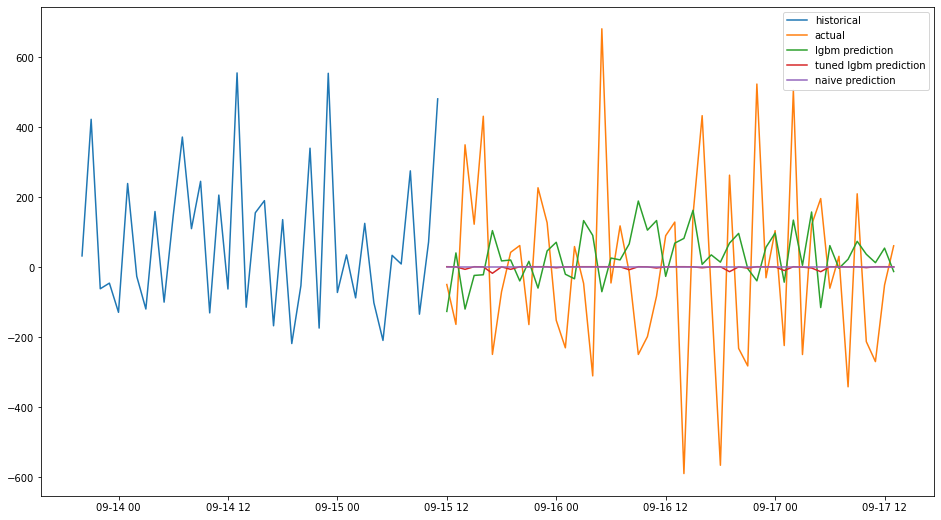

In [72]:
plt.figure(figsize = (16,9))
plt.plot(fe_df[-40 - pred_window - end_offset : -pred_window - end_offset]['time_close'], y_trn[-40:], label='historical')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_tst[:-(pred_window - 50)], label='actual')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_pred_lgbm[:-(pred_window - 50)], label='lgbm prediction')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_pred_lgbm_tuned[:-(pred_window - 50)], label='tuned lgbm prediction')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_pred_naive[:-(pred_window - 50)], label='naive prediction')
plt.legend()

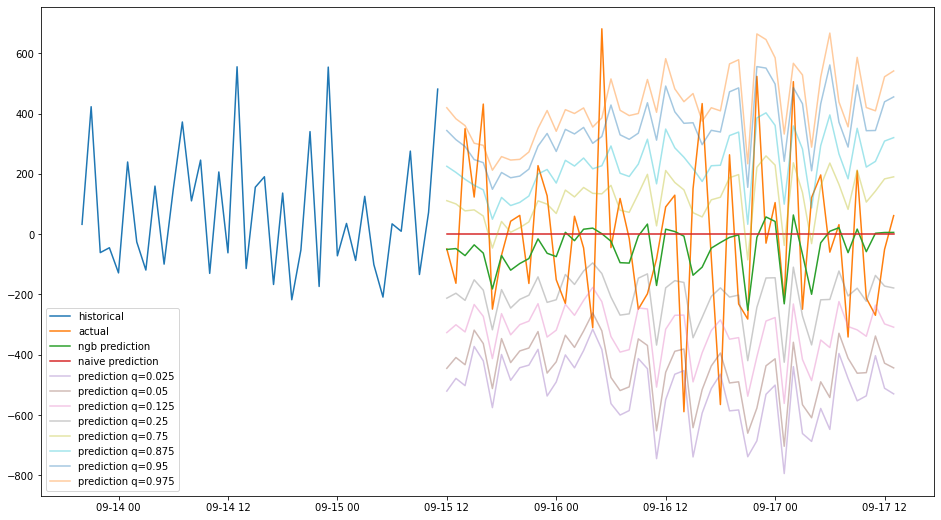

In [73]:
plt.figure(figsize = (16,9))
plt.plot(fe_df[-40 - pred_window - end_offset : -pred_window - end_offset]['time_close'], y_trn[-40:], label='historical')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_tst[:-(pred_window - 50)], label='actual')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_pred_ngb[:-(pred_window - 50)], label='ngb prediction')
plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_pred_naive[:-(pred_window - 50)], label='naive prediction')
for i in range(len(quantiles)):
    plt.plot(fe_df[-pred_window - end_offset : fe_df.shape[0] - end_offset - (pred_window - 50)]['time_close'], y_quant_pred[i][:-(pred_window - 50)], label=f'prediction q={quantiles[i]}', alpha=0.4)
plt.legend()

The visualization of the forecasts clearly show that the naive method is indeed the best forecasting method for cryptocurrency prices. It can be observed that the best machine learning model produces forecasts that are almost indistinguishable from the naive predictions.

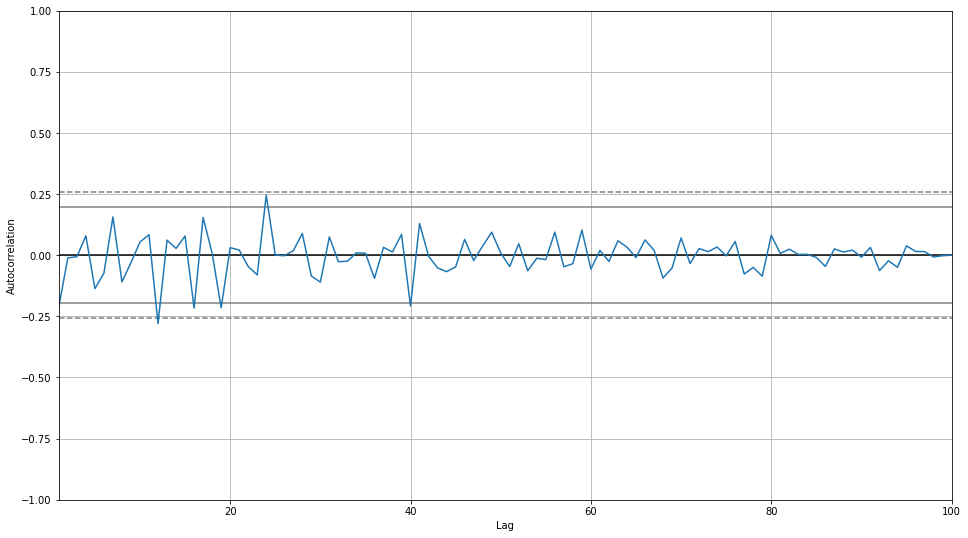

In [88]:
plt.figure(figsize = (16,9))
pd.plotting.autocorrelation_plot((np.array(y_tst) - y_pred_naive.reshape(1,-1)[0])[:100])

Further diagnostics of the residuals obtained from the naive forecast confirm that the naive forecast accounts for all available information and thus is optimal. There is no signigicant correlation in the residual series.

Evaluation scores (RMSE) of the regressors:

In [178]:
pd.DataFrame(data={
    'LightGBM' : math.sqrt(metrics.mean_squared_error(y_tst, y_pred_lgbm)),
    'Tuned LightGBM' : math.sqrt(metrics.mean_squared_error(y_tst, y_pred_lgbm_tuned)),
    'NGBoost' : math.sqrt(metrics.mean_squared_error(y_tst, y_pred_ngb)),
    'Naive' : math.sqrt(metrics.mean_squared_error(y_tst, y_pred_naive))
}, index=[0])

LightGBM  Tuned LightGBM     NGBoost       Naive
0  415.44615      384.621233  550.949534  382.195533

As expected, the evaluation results for the regressors demonstrate the same tendency observed during the validation stage, with the naïve forecast outperforming all the models according to the RMSE metric.

Percentage of correct price movement predictions (accuracy) of the regressors:

In [179]:
pd.DataFrame(data={
    'LightGBM' : sum(np.sign(y_pred_lgbm) == np.sign(y_tst)) / len(y_tst),
    'Tuned LightGBM' : sum(np.sign(y_pred_lgbm_tuned) == np.sign(y_tst)) / len(y_tst),
    'NGBoost' : sum(np.sign(y_pred_ngb) == np.sign(y_tst)) / len(y_tst),
}, index=[0])

LightGBM  Tuned LightGBM  NGBoost
0     0.506           0.496    0.506

Evaluation scores (Accuracy) of the classifiers:

In [180]:
pd.DataFrame(data={
    'LightGBM' : metrics.accuracy_score(y_class_tst, y_class_pred_lgbm),
    'Tuned LightGBM' : metrics.accuracy_score(y_class_tst, y_class_pred_lgbm_tuned)
}, index=[0])

LightGBM  Tuned LightGBM
0     0.526          0.5235

Accuracy of the classifiers has also fallen, although the models still make correct predictions more than 52% of the time. This is an interesting observation, as the accuracy on the test size of 2000 was expected to be closer to 50%.

Percentage of observations falling into the NGBoost prediction intervals:

In [181]:
pd.DataFrame(data={
    '50% PI' : sum((y_quant_pred[3] < y_tst) & (y_tst < y_quant_pred[4])) / len(y_tst),
    '75% PI' : sum((y_quant_pred[2] < y_tst) & (y_tst < y_quant_pred[5])) / len(y_tst),
    '90% PI' : sum((y_quant_pred[1] < y_tst) & (y_tst < y_quant_pred[6])) / len(y_tst),
    '95% PI' : sum((y_quant_pred[0] < y_tst) & (y_tst < y_quant_pred[7])) / len(y_tst)
}, index=[0])

50% PI  75% PI  90% PI  95% PI
0  0.5155   0.727  0.8535  0.9035

Results show that NGBoost is capable of accurately modelling price movement variability.

To further investigate the significance of the classifiers' accuracies, the accuracies of 10000 random binary forecasts are collected and the approximate distribution is modelled:

In [186]:
random_pred_scores = [sum(np.sign([1 if random.random() > 0.5 else -1 for _ in range(len(y_tst))]) == np.sign(y_tst)) / len(y_tst) for _ in range(10000)]

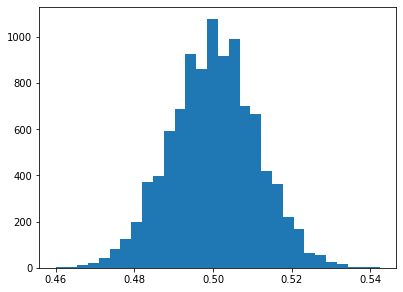

In [187]:
_ = plt.hist(random_pred_scores, bins=30)

In [188]:
random_pred_scores_loc, random_pred_scores_scale = stats.norm.fit(random_pred_scores)
random_pred_scores_dist = stats.norm(loc=random_pred_scores_loc, scale=random_pred_scores_scale)

In [189]:
random_pred_scores_loc

0.5000906999999999

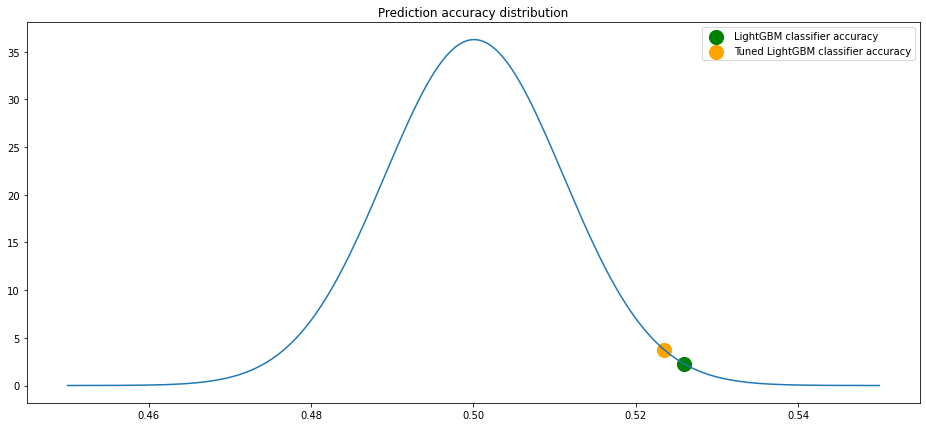

In [193]:
plt.figure(figsize = (16,7))
x = np.linspace(0.45, 0.55, 200)
plt.plot(x, random_pred_scores_dist.pdf(x))
plt.scatter([metrics.accuracy_score(y_class_tst, y_class_pred_lgbm)], random_pred_scores_dist.pdf(metrics.accuracy_score(y_class_tst, y_class_pred_lgbm)), s=200, color='green', label='LightGBM classifier accuracy')
plt.scatter([metrics.accuracy_score(y_class_tst, y_class_pred_lgbm_tuned)], random_pred_scores_dist.pdf(metrics.accuracy_score(y_class_tst, y_class_pred_lgbm_tuned)), s=200, color='orange', label='Tuned LightGBM classifier accuracy')
plt.title('Prediction accuracy distribution')
plt.legend()

In [191]:
1 - random_pred_scores_dist.cdf(metrics.accuracy_score(y_class_tst, y_class_pred_lgbm))

0.009228850080216122

In [192]:
1 - random_pred_scores_dist.cdf(metrics.accuracy_score(y_class_tst, y_class_pred_lgbm_tuned))

0.016629402189303533

With probability of observing the same accuracy as that of the classifiers being less than 2%, the result might suggest that the models are in fact able to discover some patterns in the historical data, although it is arguable.

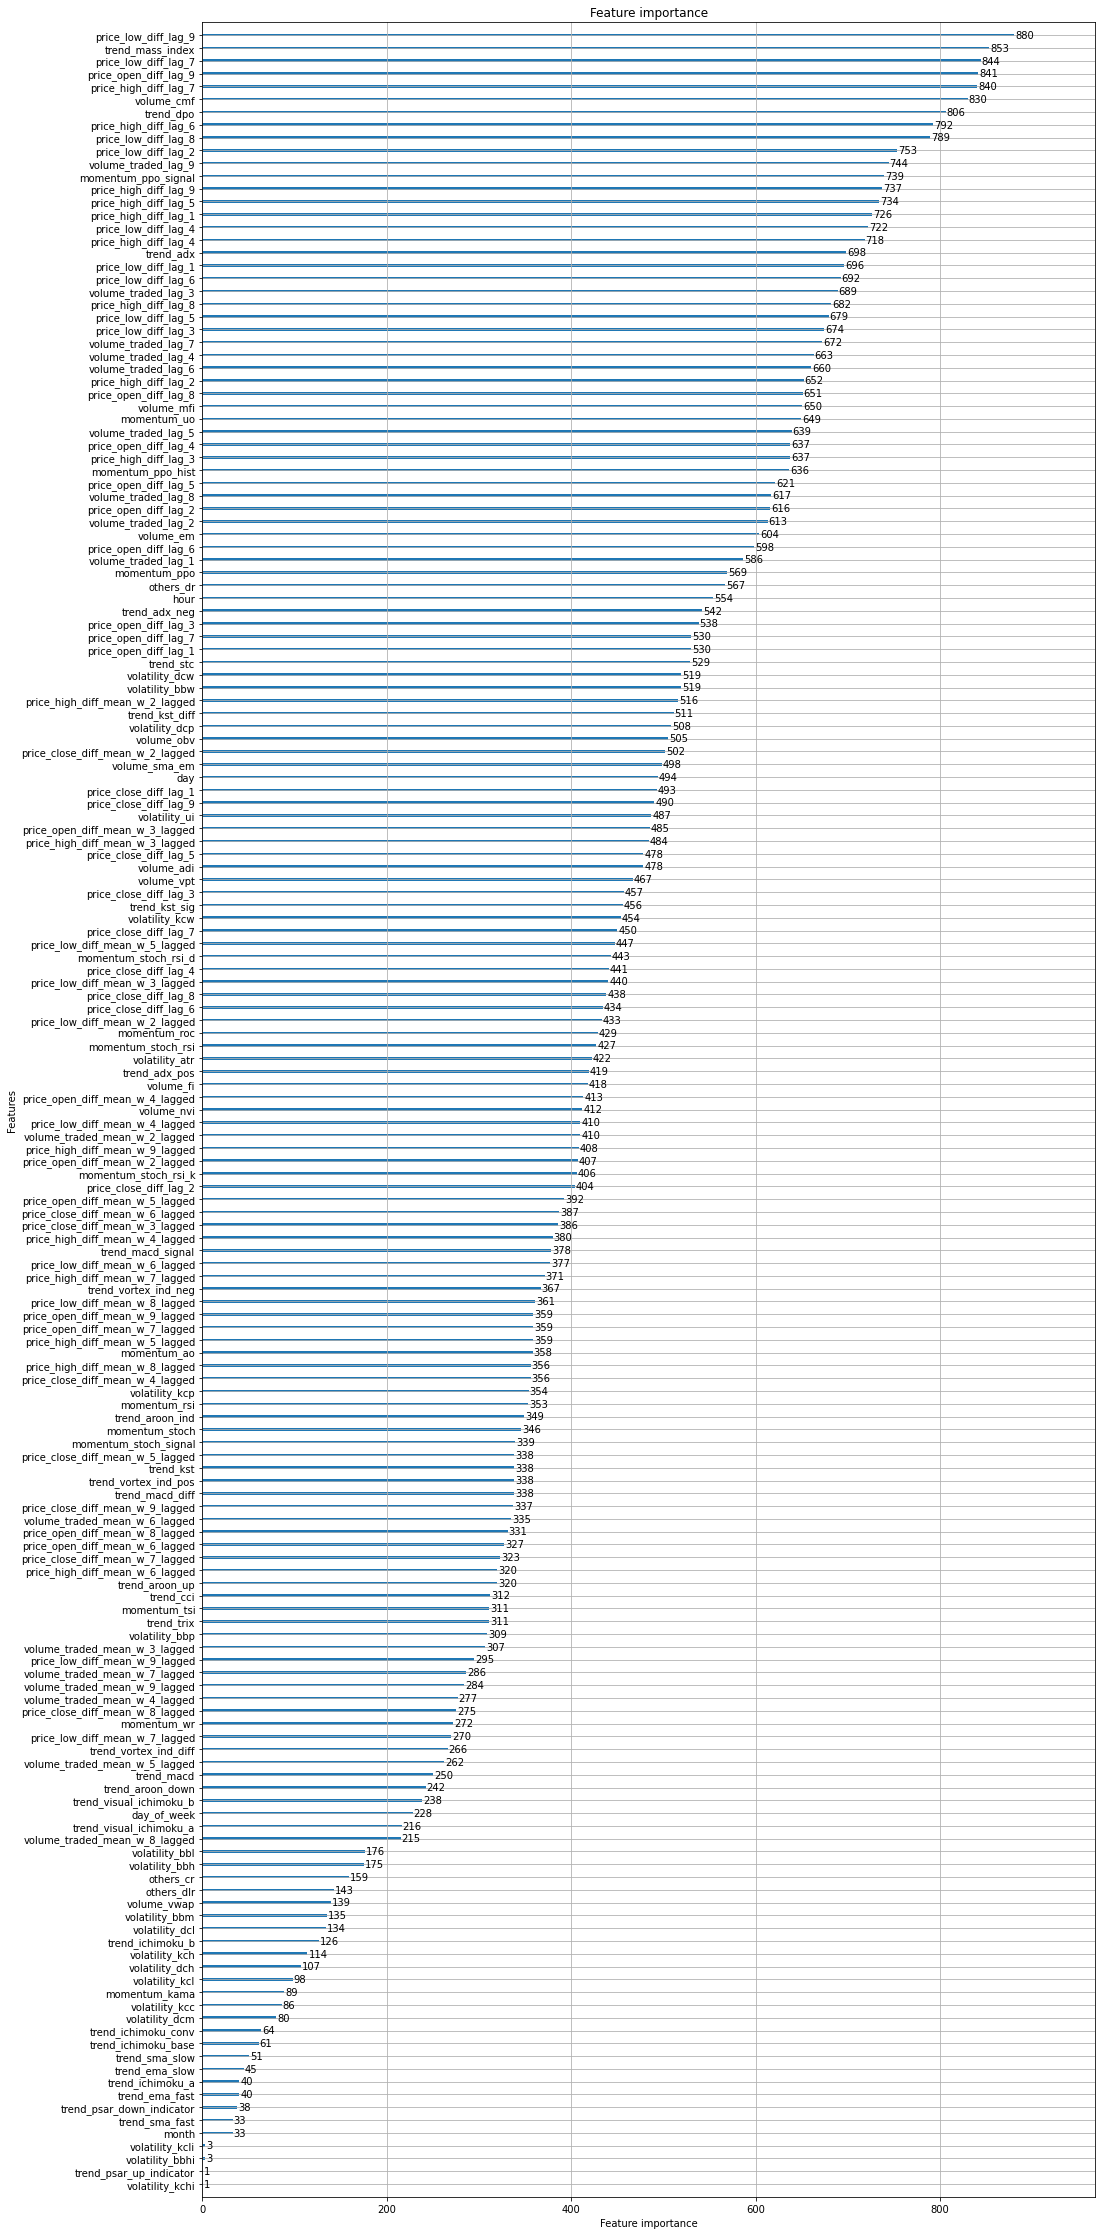

In [205]:
plt.rcParams["figure.figsize"] = (16,40)
plot_importance(lgbm_class)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

Text(0.5, 1.0, 'price_open_diff_lag_9')

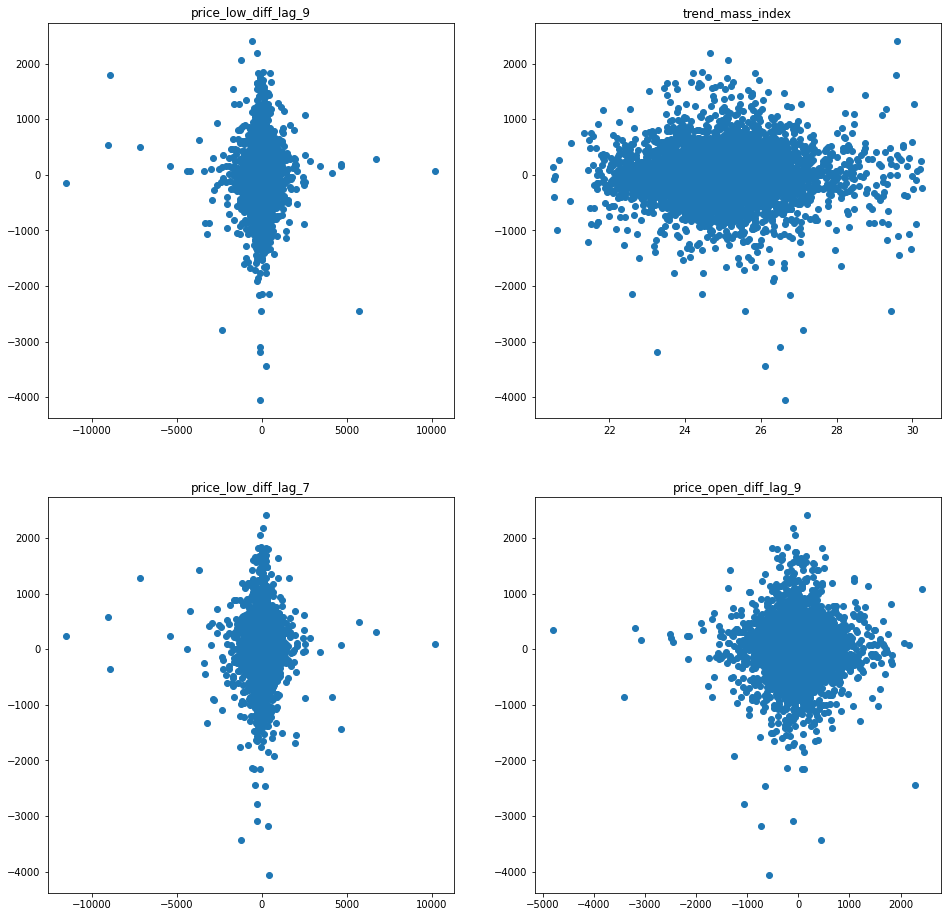

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))
axs[0, 0].scatter(fe_df['price_low_diff_lag_9'], fe_df['price_close_diff'])
axs[0, 0].set_title('price_low_diff_lag_9')
axs[0, 1].scatter(fe_df['trend_mass_index'], fe_df['price_close_diff'])
axs[0, 1].set_title('trend_mass_index')
axs[1, 0].scatter(fe_df['price_low_diff_lag_7'], fe_df['price_close_diff'])
axs[1, 0].set_title('price_low_diff_lag_7')
axs[1, 1].scatter(fe_df['price_open_diff_lag_9'], fe_df['price_close_diff'])
axs[1, 1].set_title('price_open_diff_lag_9')

Four of the most important features demonstrate no apparent correlation with the target variable, which acts in favour of the unpredictability hypothesis.

### Forecast-based trading strategy
The feasibility of cryptocurrency price movement forecasting with machine learning is further explored with a simple trading bot that receives the amount in USD and decision rules for buying and selling.

In [110]:
def trader(amount_usd, decision_rule_buy, decision_rule_sell):
    amount_btc = 0
    for i in range(pred_window):
        if decision_rule_buy(i) and amount_btc == 0:
            amount_btc = amount_usd / df.loc[len(df)-pred_window -1 + i, 'price_close']
            amount_usd = 0
        elif decision_rule_sell(i) and amount_btc != 0:
            amount_usd = amount_btc * df.loc[len(df)-pred_window -1 + i, 'price_close']
            amount_btc = 0

    if amount_usd == 0:
        amount_usd = amount_btc * df.loc[len(df)-1, 'price_close']
        amount_btc = 0
    
    return amount_usd

The trading bot will buy BTC if both of the top-performing models predict the positive move in price and sell if either of the models predicts the negative change in the price.

In [129]:
forecast_based_outcome = trader(
    amount_usd=5000,
    decision_rule_buy=lambda i: y_class_pred_lgbm[i] > 0 and y_class_pred_lgbm_tuned[i] > 0,
    decision_rule_sell=lambda i: y_class_pred_lgbm[i] < 0 or y_class_pred_lgbm_tuned[i] < 0
)

In [130]:
forecast_based_outcome

5447.640397421049

In [194]:
(forecast_based_outcome - 5000) / 5000

0.08952807948420978

Similarly to the experiment used to compare the accuracy of the predictions produced by the models with randomly produced forecasts, 10000 outcomes were generated by running the trading bot with random sell and buy rules and the start amount set to $5,000. 

In [195]:
random_outcomes = [trader(5000, lambda _: random.random() > 0.5, lambda _: random.random() > 0.5) for i in range(10000)]

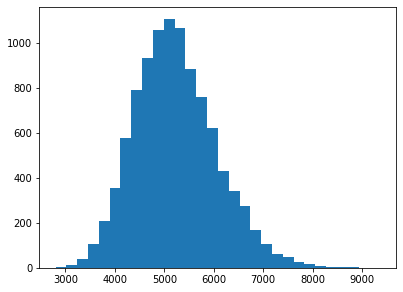

In [196]:
_ = plt.hist(random_outcomes, bins=30)

In [197]:
random_outcomes_skew, random_outcomes_loc, random_outcomes_scale = stats.skewnorm.fit(random_outcomes)
random_outcomes_dist = stats.skewnorm(a=random_outcomes_skew, loc=random_outcomes_loc, scale=random_outcomes_scale)

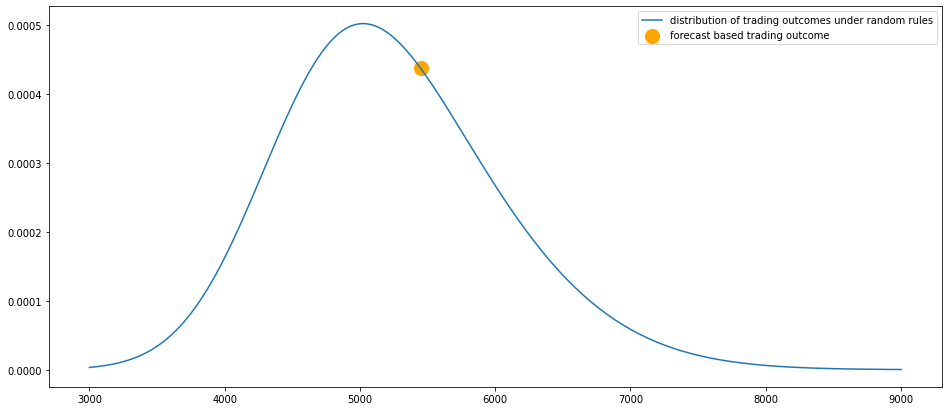

In [199]:
plt.figure(figsize = (16,7))
x = np.linspace(3000, 9000, 200)
plt.plot(x, random_outcomes_dist.pdf(x), label='distribution of trading outcomes under random rules')
plt.scatter([forecast_based_outcome], random_outcomes_dist.pdf(forecast_based_outcome), color='orange', s=200, label='forecast based trading outcome')
plt.legend()

In [200]:
1 - random_outcomes_dist.cdf(forecast_based_outcome)

0.36799689229030685

According to the obtained results, the probability of getting the same or higher outcome than that produced with the forecast-based trading rules is as high as 0.368. This finding shows that building the trading strategy that is capable of correctly using the forecasts that are correct more than 50% of the time is a more sophisticated task than producing the forecasts themselves.